In [209]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import copy
from functools import reduce
from scipy import stats
from tabulate import tabulate
import matplotlib as mb
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
from datetime import date
from prettytable import PrettyTable

### Prepare datasets for figures

In [210]:
def get_fig_input(timewindow:str)->tuple:
    """Prepare the figure inputs for both alltime and daytime dataset.

    Args:
        timewindow (str): specify what isotope scale does this figure input data is preparing for. 

    Raises:
        ValueError: inconsistency in number of NEON sites.

    Returns:
        tuple: three pandas.DataFrame contains data for different plots. 
               0th --> descriptive statistics, 1th --> for figure 1 to 3, 2th --> for figure 4 and other SI figs.
    """
    
    # this modified version won't support daytime data. 
    assert timewindow == "alltime", "Only takes daytime or alltime."
    # the file that stores the correspondent results in .csv.
    resultPath = '../MI_results/'
    # site specific variables .csv file downloaded from NEON 
    siteInfo = pd.read_csv('../190115-field-sites.csv')
    # we only need to 'Core Terrestrial' and 'Relocatable Terrestrial'
    siteInfo = siteInfo[(siteInfo['Site Type'] == 'Core Terrestrial')|
                        (siteInfo['Site Type'] == 'Relocatable Terrestrial')]
    siteMete = copy.deepcopy(siteInfo[['Site ID', 'Mean Annual Temperature',
                                       'Mean Annual Precipitation','Elevation', 'Lat./Long.']])
    if siteInfo.shape[0] != siteMete.shape[0]:
        raise ValueError("Inconsistent number of sites found.")
    # parse site information from  site_Meter
    siteMete['site'] = siteMete['Site ID'].apply(lambda x: x) # str of 4 letters
    siteMete['MAT'] = siteMete['Mean Annual Temperature'].apply(lambda x: float(x.split('C')[0])) # MAT in format of "xxxCxxxF", use degree C only
    siteMete['MAP'] = siteMete['Mean Annual Precipitation'].apply(lambda x: float(x.split('mm')[0])) # MAP in mm/year, i think
    siteMete['Elev'] = siteMete['Elevation'].apply(lambda x: float(x.split('m')[0])) # Elevation in m 
    siteMete['Lat'] = siteMete['Lat./Long.'].apply(lambda x: float(x.split(',')[0])) # latitude 
    siteMete['Lon'] = siteMete['Lat./Long.'].apply(lambda x: float(x.split(',')[1])) # longitude
    siteMete = siteMete.sort_values(by = 'site', ignore_index=True)
    ## this dataset is from Rich et.al.,JGR Biogeosciences 10.1029/2020JG005862 Figure 3b.
    ## originally is P/PET --> the larger the wetter, here we change to PET/P --> the larger the drier
    aridityCanopy = pd.read_csv("../NEONaridityandcanopy.csv", index_col= 0)
    
    aridityCanopy['aridity'] = 1/aridityCanopy['aridity'] ##original is P/PET, now convert aridity to PET/P
    aridityCanopy = aridityCanopy.sort_values(by = 'site', ignore_index=True)
    envirVars = pd.merge(aridityCanopy, siteMete, on = 'site', how = 'inner')
    # myData = pd.read_csv(resultPath + f'MI_and_PID_NEON_{timewindow}_iso.csv') ## pay attention to here
    ## pay attention to here, we used the most up-to-date MI results
    # info_quantities = pd.read_csv(resultPath + f'MI_and_PID_NEON_{timewindow}_iso_02032023.csv') 
    info_quantities = pd.read_csv(resultPath + f'MI_and_PID_NEON_{timewindow}_iso_time_correctd_2023-04-12.csv')  # use the time corrected results 
    info_quantities = info_quantities.sort_values(by = 'site', ignore_index=True)
    ## prepare the dataset for spatial maps. 
    forSpatial = reduce(lambda x, y: pd.merge(x, y, on = 'site', how = 'inner'),
                   [info_quantities[['site','U(NEE;C13)', 'S(NEE;C13)', 'R(NEE;C13)','U+S(NEE;C13)',
                            'U(LH;C13)', 'S(LH;C13)', 'R(LH;C13)','U+S(LH;C13)',
                            'U(NEE;H2)', 'S(NEE;H2)', 'R(NEE;H2)','U+S(NEE;H2)',
                            'U(LH;H2)', 'S(LH;H2)', 'R(LH;H2)','U+S(LH;H2)',
                            'U(NEE;dEx)', 'S(NEE;dEx)', 'R(NEE;dEx)','U+S(NEE;dEx)',
                            'U(LH;dEx)', 'S(LH;dEx)', 'R(LH;dEx)','U+S(LH;dEx)']], siteMete[['site','Lat', 'Lon']]])
    ## prepare the dataset for figure 1 to figure 3 
    finalData = pd.merge(info_quantities, envirVars, on = 'site', how = 'inner')
    return info_quantities, finalData, forSpatial 

### Get the shuffled test results

In [211]:
def shuffle_test(timewindow:str)->pd.DataFrame:
    """Perform a paired/related t-test for each information quantity.

    Args:
        timewindow (str): specify what isotope scale does this figure input data is preparing for. 

    Returns:
        pandas.DataFrame: two dataframes contains test results for ONLY alltime dataset.
    """
    
    # shufflePath = 'C:/Users/libon/Box/neon_extrac_data/results/shuffled_unnorm_2021_10_13/'
    # shufflePath = f'../ShuffleMIs/{timewindow}/' # shuffleMIs 50 .csv files
    # shufflePath = f'../ShuffleMIs/{timewindow}_2023/' # shuffleMIs 50 .csv files generated based on results from 2023
    shufflePath = f'../ShuffleMIs/{timewindow}_2023_time_corrected/' # shuffleMIs 50 .csv files generated based on results from 2023

    infoPath = '../MI_results/'
    infoQuantities = pd.read_csv(infoPath + f'MI_and_PID_NEON_{timewindow}_iso_time_correctd_2023-04-12.csv') # resutls from 2023 time corrected
    infoQuantities = infoQuantities.sort_values(by = 'site', ignore_index=True) # sort info-quantity dataframe by site
    # stacking 50 information quanty dataframes together
    allunshf = pd.concat([infoQuantities for i in np.arange(50)])
    allshuffle = []
    for i in os.listdir(shufflePath):
        tmef =  pd.read_csv(shufflePath + i)
        tmef = tmef.sort_values(by = 'site', ignore_index=True)
        assert all(infoQuantities.columns == tmef.columns), "column names should be the same for testing."
        assert all(infoQuantities['site'] == tmef['site']), "site names should be in order for testing."
        allshuffle.append(tmef)
     # stacking 50 shuffled information quantity dataframes together
    allshuffle =  pd.concat(allshuffle) 

    assert all(allshuffle.columns == allunshf.columns), "column names should be the same for testing."
    assert all(allshuffle['site'] == allunshf['site']),  "site names should be in order for testing."
    testArray = pd.DataFrame([], columns = allshuffle.columns[1:], index = ['pvalues', 'tstats'])
    # loop through each column and then perform a paired t-test 
    for i in allshuffle.columns[1:]:
        dtt = pd.merge(allunshf[['site',i]],allshuffle[['site',i]], on = 'site').dropna()
        """
        This is a test for the null hypothesis that two related or repeated samples have IDENTICAL average (expected) values.
        "greater": the mean of the distribution underlying the FIRST sample is greater than the mean of the distribution underlying the SECOND sample.
        The test measures whether the average score differs significantly across samples (e.g. exams). 
        
        If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores.
        If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages. 
        Small p-values are associated with large t-statistics. 
        The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
        Therefore, the t-statistic will be positive when the sample mean of a - b is greater than zero
        and negative when the sample mean of a - b is less than zero.
        """
        t_test = stats.ttest_rel(dtt[i + '_x'], dtt[i + '_y'], alternative = 'greater')
        testArray.loc['pvalues', i] = t_test[1] 
        testArray.loc['tstats', i] = t_test[0]
    return testArray

In [212]:
def get_fig1(ds, timewindow, saveFig = False):
    """Produce figure 1 i.e., mutual information plot of the paper. 

    Args:
        ds (pandas.DataFrame): data for figure 1.
        timewindow (str): Only accept "alltime"
        saveFig (bool, optional): if the figure is saved or not. Defaults to False.
    """
    plt.style.use('seaborn')
    fig1, ax1 = plt.subplots(2, 1, figsize = (25,16))
    ttest_results = shuffle_test(timewindow)
    clss = ['gold', 'darkcyan', 'olive', 'hotpink', 'fuchsia',
            'gold', 'darkcyan', 'olive', 'hotpink', 'royalblue',
            'gold', 'darkcyan', 'olive', 'hotpink', 'dimgray']

    # list of labels for NEE subplot
    labelNEE = [
                '$I$($VPD$;$NEE$)', '$I$($T$;$NEE$)',
                '$I$($R_{g}$;$NEE$)','$I$($u$;$NEE$)',
                '$I$($\delta ^{13}C$;$NEE$)',
              
                '$I$($VPD$;$NEE$)', '$I$($T$;$NEE$)',
                '$I$($R_{g}$;$NEE$)', '$I$($u$;$NEE$)',
                '$I$($\delta ^{2}H$;$NEE$)',
              
                '$I$($VPD$;$NEE$)', '$I$($T$;$NEE$)',
                '$I$($R_{g}$;$NEE$)','$I$($u$;$NEE$)',
                '$I$($d$;$NEE$)'
                ]
    
    fieldNEE = [
                'I(NEE;VPD)13', 'I(NEE;T)13', 
                'I(NEE;R)13', 'I(NEE;u)13','I(NEE;C13)',
                
                'I(NEE;VPD)2', 'I(NEE;T)2', 
                'I(NEE;R)2', 'I(NEE;u)2','I(NEE;H2)',
            
                'I(NEE;VPD)dx', 'I(NEE;T)dx', 
                'I(NEE;R)dx', 'I(NEE;u)dx','I(NEE;dEx)'
                ]
    
    # list of labels for LH subplots
    labelLH = [
                '$I$($VPD$;$LH$)', '$I$($T$;$LH$)',
                '$I$($R_{g}$;$LH$)','$I$($u$;$LH$)',
                '$I$($\delta ^{13}C$;$LH$)',
              
                '$I$($VPD$;$LH$)', '$I$($T$;$LH$)',
                '$I$($R_{g}$;$LH$)','$I$($u$;$LH$)',
                '$I$($\delta ^{2}H$;$LH$)',
              
                '$I$($VPD$;$LH$)', '$I$($T$;$LH$)',
                '$I$($R_{g}$;$LH$)', '$I$($u$;$LH$)',
                '$I$($d$;$LH$)'
                ]
     
                      
    fieldLH = [
                'I(LH;VPD)13', 'I(LH;T)13', 
                'I(LH;R)13', 'I(LH;u)13','I(LH;C13)',
                
                'I(LH;VPD)2', 'I(LH;T)2', 
                'I(LH;R)2', 'I(LH;u)2','I(LH;H2)',
                
                'I(LH;VPD)dx', 'I(LH;T)dx', 
                'I(LH;R)dx', 'I(LH;u)dx','I(LH;dEx)'
                ]   
    # only works on the copy of the dataframe
    NEEdf = ds[fieldNEE].copy()
    LHdf = ds[fieldLH].copy()
    
    # loop through each mutual information quantities
    loop_iterations = len(fieldNEE)
    for s in np.arange(loop_iterations):
        # define box and whisker styles
        commonDirc = {'boxprops': dict(linewidth = 5, color = clss[s]),
                       'whiskerprops':dict(linewidth =5,linestyle = 'solid'),
                       'medianprops':dict(linewidth = 5, zorder = 9, color= 'white'),
                       'capprops': dict(linewidth =5),
                       'meanprops':dict(marker = '^',
                                   markersize = 15, zorder = 10, 
                                   markeredgecolor='black',
                                   markerfacecolor='black'),
                       'flierprops':dict(marker='o',
                                         markerfacecolor=clss[s],
                                         markersize=12,
                                         linestyle='none',
                                         markeredgecolor=clss[s])
                       }
        
        # left subplot for NEE, remove nans while using boxplot
        b1 = ax1[0].boxplot(NEEdf.loc[:,fieldNEE[s]].dropna(), widths = 0.45,
                   notch = False, labels = [labelNEE[s]],
                   showmeans = True, positions = [s],patch_artist=True,
                   showfliers = True,**commonDirc)
        b1['boxes'][0].set(facecolor = clss[s])
        b1['caps'][0].set(color=clss[s])   
        b1['caps'][1].set(color=clss[s])     
        b1['whiskers'][0].set(color=clss[s])
        b1['whiskers'][1].set(color=clss[s])
        [ax1[1].axvline(4.5 + i*5,color='white', linestyle = 'dashed',
                        linewidth = 3) for i in range(2)]
        
        p_value_nee = ttest_results.loc['pvalues',fieldNEE[s]]
        t_value_nee = ttest_results.loc['tstats',fieldNEE[s]]
       
        if (p_value_nee < 0.01) and (t_value_nee > 0):
            ax1[0].annotate('**', xy=(s-0.1,1.2), fontsize=25)
        
        if (0.01 <= p_value_nee < 0.05) and (t_value_nee > 0):
            ax1[0].annotate('*', xy=(s-0.1,1.2), fontsize=25)

        # right subplot for LH, remove nans while using boxplot
        b2 = ax1[1].boxplot(LHdf.loc[:,fieldLH[s]].dropna(), widths = 0.45,
                    notch = False, labels = [labelLH[s]],patch_artist=True,
                    showmeans = True, positions = [s],
                    showfliers = True,**commonDirc)
        b2['boxes'][0].set(facecolor = clss[s])
        
        b2['boxes'][0].set(facecolor = clss[s])
        b2['caps'][0].set(color=clss[s])   
        b2['caps'][1].set(color=clss[s])     
        b2['whiskers'][0].set(color=clss[s])
        b2['whiskers'][1].set(color=clss[s])
        [ax1[0].axvline(4.5 + i*5, color = 'white',linestyle = 'dashed',
                        linewidth =3) for i in range(2)]
        p_value_lh = ttest_results.loc['pvalues', fieldLH[s]]
        t_value_lh = ttest_results.loc['tstats', fieldLH[s]]
        if (p_value_lh < 0.01) and (t_value_lh > 0):
            ax1[1].annotate('**', xy=(s-0.1,1.2), fontsize=25)
            
        if (0.01 < p_value_lh < 0.05) and (t_value_lh > 0):
            ax1[1].annotate('*', xy=(s-0.1,1.2), fontsize=25)
        
    ax1[0].set_ylim([-0.05,1.3]) # set the ylim for visualization, change back to 1.1 if unNorm
    ax1[1].set_ylim([-0.05,1.3]) # set the ylim for visualization change back to 1.1 if unNorm
    
    
    ax1[0].set_ylabel('Mutual information (bits)',fontsize =  22)
    ax1[1].set_ylabel('Mutual information (bits)',fontsize =  22)
 
    ax1[0].annotate('a', xy=(0.95,0.8), 
                    xycoords='axes fraction', 
                    fontsize=30,
                    horizontalalignment='right',
                    verticalalignment='bottom') 
    
    ax1[1].annotate('b', xy=(0.95,0.8), 
                    xycoords='axes fraction', 
                    fontsize=30,
                    horizontalalignment='right',
                    verticalalignment='bottom') 

    ax1[0].tick_params(axis= 'both', labelsize= 16)
    ax1[1].tick_params(axis= 'both', labelsize= 16)
    
    
    ax1[0].annotate('Calculated based on $\delta ^{13}C$ availability', xy=(0.28,1), 
                    xycoords='axes fraction', 
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom') 
    ax1[0].annotate('Calculated based on $\delta ^{2}H$ availability', xy=(0.62,1), 
                xycoords='axes fraction', 
                fontsize=20,
                horizontalalignment='right',
                verticalalignment='bottom') 
    ax1[0].annotate('Calculated based on $d$ availability', xy=(0.93,1), 
            xycoords='axes fraction', 
            fontsize=20,
            horizontalalignment='right',
            verticalalignment='bottom') 
    
    plt.subplots_adjust(wspace=0.12,hspace=0.08)
    print(ttest_results.T)
    if saveFig:
        # figPath = get_fig_path(timewindow)
        today = date.today()
        today = today.strftime("%b-%d-%Y")
        figPath = "../Figures/ERL_alltime_fig/"
        fig1.savefig(figPath + f"/ERL_MI_fig_{today}_time_corrected.png",
                           bbox_inches = 'tight', pad_inches = 0.1)

In [213]:
def shuffle_test_stacked_fig1(timewindow:str, flux:str)->pd.DataFrame:
    """Perform a paired/related t-test for each information quantity.

    Args:
        timewindow (str): specify what isotope scale does this figure input data is preparing for. 
        flux (str): specify whether NEE or LH is tested.

    Returns:
        pandas.DataFrame: two dataframes contains test results for ONLY alltime dataset.
    """
    shufflePath = f'../ShuffleMIs/{timewindow}_2023_time_corrected/' # shuffleMIs 50 .csv files generated based on results from 2023

    infoPath = '../MI_results/'
    infoQuantities = pd.read_csv(infoPath + f'MI_and_PID_NEON_{timewindow}_iso_time_correctd_2023-04-12.csv') # resutls from 2023 time corrected
    infoQuantities = infoQuantities.sort_values(by = 'site', ignore_index=True) # sort info-quantity dataframe by site
    # significant test for fluxes
   
    hub_require_testing = {'VPD': pd.concat([infoQuantities[i]for i in  [f'I({flux};VPD)13',f'I({flux};VPD)2',f'I({flux};VPD)dx']],
                                            ignore_index=True),
                           'T':pd.concat([infoQuantities[i] for i in [f'I({flux};T)13',f'I({flux};T)2',f'I({flux};T)dx']],
                                         ignore_index=True), 
                           'R':pd.concat([infoQuantities[i] for i in [f'I({flux};R)13',f'I({flux};R)2', f'I({flux};R)dx']],
                                         ignore_index=True), 
                           'u':pd.concat([infoQuantities[i] for i in [f'I({flux};u)13',f'I({flux};u)2', f'I({flux};u)dx']],
                                         ignore_index=True), 
                           f'I({flux};C13)':infoQuantities[f'I({flux};C13)'], 
                           f'I({flux};H2)':infoQuantities[f'I({flux};H2)'], 
                           f'I({flux};dEx)':infoQuantities[f'I({flux};dEx)']}
    labels = ['VPD', 'T', 'R', 'u', f'I({flux};C13)', f'I({flux};H2)',f'I({flux};dEx)']
    
    
    # Concat the MIs from the shuffle dataset and concat them in var and file
    all_shuffle_vars = {}
    for l in labels:
        var_data = []
        for j in os.listdir(shufflePath):
            tmef =  pd.read_csv(shufflePath + j)
            tmef = tmef.sort_values(by = 'site', ignore_index=True)
            # now stacking each indiviual variable 
            if l in ["VPD", "T", "R", "u"]:
                shuffle_var = pd.concat([tmef[i]for i in  [f'I({flux};{l})13',f'I({flux};{l})2',f'I({flux};{l})dx']],
                                                ignore_index=True)
            else:
                shuffle_var = tmef[l].copy()
            var_data.append(shuffle_var)
        # concat the var 
        all_shuffle_vars[l] = pd.concat(var_data,ignore_index=True)
    # now collect the results 
    test_results = {}
    for single_var in labels:  
        stacked_var = pd.concat([hub_require_testing[single_var] for i in np.arange(50)], ignore_index=True) 
        """
        This is a test for the null hypothesis that two related or repeated samples have IDENTICAL average (expected) values.
        "greater": the mean of the distribution underlying the FIRST sample is greater than the mean of the distribution underlying the SECOND sample.
        The test measures whether the average score differs significantly across samples (e.g. exams). 
        
        If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores.
        If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages. 
        Small p-values are associated with large t-statistics. 
        The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
        Therefore, the t-statistic will be positive when the sample mean of a - b is greater than zero
        and negative when the sample mean of a - b is less than zero.
        """
        t_test = stats.ttest_rel(stacked_var.dropna().values, all_shuffle_vars[single_var].dropna().values,alternative = 'greater')
        if single_var in ["VPD", "T", "R", "u"]:
            test_results[f"{single_var}_{flux}"] = t_test
        else:
             test_results[f"{single_var}"] = t_test
    return test_results

In [214]:
def get_stacked_fig1(ds:pd.DataFrame, timewindow:str, saveFig:bool = False)->None:
    """Plot the stacked version of <get_fig1>
    Args:
        ds (pd.DataFrame): Data for figure1 plotting.
        timewindow (str): Indicate the isotope data used.
        saveFig (bool, optional): If the displayed figure is saved. Defaults to False.
    """
    plt.style.use('seaborn')
    clss = ['gold', 'darkcyan', 'olive',
            'hotpink', 'fuchsia','royalblue','dimgray']

    fig1, ax1 = plt.subplots(1, 2, figsize = (17,7))
    # Information of NEE 
    labelNEE = [
                '$I$($VPD$;$NEE$)', '$I$($T$;$NEE$)',
                '$I$($R_{g}$;$NEE$)','$I$($u$;$NEE$)',
                '$I$($\delta ^{13}C$;$NEE$)',
                '$I$($\delta ^{2}H$;$NEE$)',
                '$I$($d$;$NEE$)'
                ]
    
    VPD_nee = pd.concat([ds[i] for i in  ['I(NEE;VPD)13','I(NEE;VPD)2','I(NEE;VPD)dx']])
    T_nee = pd.concat([ds[i] for i in ['I(NEE;T)13','I(NEE;T)2','I(NEE;T)dx']])
    R_nee  = pd.concat([ds[i] for i in ['I(NEE;R)13','I(NEE;R)2', 'I(NEE;R)dx']])
    u_nee = pd.concat([ds[i] for i in ['I(NEE;u)13','I(NEE;u)2', 'I(NEE;u)dx']])
    
    
    
    # Information of LH
    labelLH = [
                '$I$($VPD$;$LH$)', '$I$($T$;$LH$)',
                '$I$($R_{g}$;$LH$)','$I$($LH$;$u$)',
                '$I$($\delta ^{13}C$;$LH$)',
                '$I$($\delta ^{2}H$;$LH$)',
                '$I$($d$;$LH$)'
                ]
    VPD_lh = pd.concat([ds[i] for i in  ['I(LH;VPD)13','I(LH;VPD)2','I(LH;VPD)dx']])
    T_lh = pd.concat([ds[i] for i in ['I(LH;T)13','I(LH;T)2','I(LH;T)dx']])
    R_lh  = pd.concat([ds[i] for i in ['I(LH;R)13','I(LH;R)2', 'I(LH;R)dx']])
    u_lh = pd.concat([ds[i] for i in ['I(LH;u)13','I(LH;u)2', 'I(LH;u)dx']])
    
    # NEE data & labels
    NEE_label_indicator = ['VPD_NEE', 'T_NEE', 'R_NEE','u_NEE','I(NEE;C13)','I(NEE;H2)', 'I(NEE;dEx)']
    data_hub_nee = [VPD_nee, T_nee, R_nee, u_nee, ds['I(NEE;C13)'], ds['I(NEE;H2)'], ds['I(NEE;dEx)']]
    NEE_test_results = shuffle_test_stacked_fig1("alltime","NEE")
    # Descriptive stats 
    from tabulate import tabulate
    print(tabulate([['NEE'] + ds['I(NEE;C13)'].describe().index.to_list(),
                    ['VPD'] + [round(i,4) for i in VPD_nee.describe().tolist()], 
                    ['T']   + [round(i,4) for i in T_nee.describe().tolist()], 
                    ['R']   + [round(i,4) for i in R_nee.describe().tolist()],
                    ['u']   + [round(i,4) for i in u_nee.describe().tolist()],
                    ['C13'] + [round(i,4) for i in ds['I(NEE;C13)'].describe().tolist()],
                    ['H2']  + [round(i,4) for i in ds['I(NEE;H2)'].describe().tolist()],
                    ['dEx'] + [round(i,4) for i in ds['I(NEE;dEx)'].describe().tolist()]],
                    tablefmt='grid'))
    
    print()
    print()
    # LH data & labels
    LH_label_indicator = ['VPD_LH', 'T_LH', 'R_LH','u_LH','I(LH;C13)','I(LH;H2)', 'I(LH;dEx)']
    data_hub_lh = [VPD_lh, T_lh, R_lh, u_lh, ds['I(LH;C13)'], ds['I(LH;H2)'], ds['I(LH;dEx)']]
    LH_test_results = shuffle_test_stacked_fig1("alltime","LH")
    # Descriptive stats for LH
    print(tabulate([['LH'] + ds['I(LH;C13)'].describe().index.to_list(),
                    ['VPD'] + [round(i,4) for i in VPD_lh.describe().tolist()], 
                    ['T']   + [round(i,4) for i in T_lh.describe().tolist()], 
                    ['R']   + [round(i,4) for i in R_lh.describe().tolist()],
                    ['u']   + [round(i,4) for i in u_lh.describe().tolist()],
                    ['C13'] + [round(i,4) for i in ds['I(LH;C13)'].describe().tolist()],
                    ['H2']  + [round(i,4) for i in ds['I(LH;H2)'].describe().tolist()],
                    ['dEx'] + [round(i,4) for i in ds['I(LH;dEx)'].describe().tolist()]],
                    tablefmt='grid'))
    
    iters = len(data_hub_nee)
    for s in np.arange(iters):
        # define box and whisker styles
        commonDirc = {'boxprops': dict(linewidth = 3, color = clss[s]),
                       'whiskerprops':dict(linewidth =3,linestyle = 'solid'),
                       'medianprops':dict(linewidth = 3, zorder = 9, color= 'white'),
                       'capprops': dict(linewidth =3),
                       'meanprops':dict(marker = '^',
                                   markersize = 10, zorder = 10, 
                                   markeredgecolor='black',
                                   markerfacecolor='black'),
                       'flierprops':dict(marker='o',
                                         markerfacecolor=clss[s],
                                         markersize=8,
                                         linestyle='none',
                                         markeredgecolor=clss[s])
                       }
        
        # left subplot for NEE, remove nans while using boxplot
        b1 = ax1[0].boxplot(data_hub_nee[s].dropna(), widths = 0.45,
                   notch = False, labels = [labelNEE[s]],
                   showmeans = True, positions = [s],patch_artist=True,
                   showfliers = True,**commonDirc)
        b1['boxes'][0].set(facecolor = clss[s])
        b1['caps'][0].set(color=clss[s])   
        b1['caps'][1].set(color=clss[s])     
        b1['whiskers'][0].set(color=clss[s])
        b1['whiskers'][1].set(color=clss[s])
        
        p_value_nee = NEE_test_results[f"{NEE_label_indicator[s]}"].pvalue
        t_value_nee = NEE_test_results[f"{NEE_label_indicator[s]}"].statistic
        print(f"The pvalue and t-test statistic for {NEE_label_indicator[s]} are {p_value_nee} and {t_value_nee}, respectively.")
       
        if (p_value_nee < 0.01) and (t_value_nee > 0):
            ax1[0].annotate('**', xy=(s-0.15,1.2), fontsize=25)
        
        if (0.01 <= p_value_nee < 0.05) and (t_value_nee > 0):
            ax1[0].annotate('*', xy=(s-0.15,1.2), fontsize=25)

        # right subplot for LH, remove nans while using boxplot
        b2 = ax1[1].boxplot(data_hub_lh[s].dropna(), widths = 0.45,
                    notch = False, labels = [labelLH[s]],patch_artist=True,
                    showmeans = True, positions = [s],
                    showfliers = True,**commonDirc)
        b2['boxes'][0].set(facecolor = clss[s])
        
        b2['boxes'][0].set(facecolor = clss[s])
        b2['caps'][0].set(color=clss[s])   
        b2['caps'][1].set(color=clss[s])     
        b2['whiskers'][0].set(color=clss[s])
        b2['whiskers'][1].set(color=clss[s])
        ax1[0].set_ylim([-0.05,1.3]) # set the ylim for visualization, change back to 1.1 if unNorm
        ax1[1].set_ylim([-0.05,1.3]) # set the ylim for visualization change back to 1.1 if unNorm
    
    
        p_value_lh = LH_test_results[f"{LH_label_indicator[s]}"].pvalue
        t_value_lh = LH_test_results[f"{LH_label_indicator[s]}"].statistic
        if (p_value_lh < 0.01) and (t_value_lh > 0):
            ax1[1].annotate('**', xy=(s-0.15,1.2), fontsize=25)
            
        if (0.01 < p_value_lh < 0.05) and (t_value_lh > 0):
            ax1[1].annotate('*', xy=(s-0.15,1.2), fontsize=25)
            
        print(f"The pvalue and t-test statistic for {LH_label_indicator[s]} are {p_value_lh} and {t_value_lh}, respectively.")

    ax1[0].annotate('a', xy=(0.95,0.8), 
                    xycoords='axes fraction', 
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom') 
    ax1[1].annotate('b', xy=(0.95,0.8), 
                    xycoords='axes fraction', 
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom') 
    ax1[0].tick_params(axis= 'both', labelsize= 12)
    ax1[1].tick_params(axis= 'both', labelsize= 12)

    ax1[0].set_ylabel('Mutual information (bits)',fontsize =  18)
    plt.subplots_adjust(wspace=0.1,hspace=0.08)
    if saveFig:
        # figPath = getFigPath(timewindow) 
        today = date.today()
        today = today.strftime("%b-%d-%Y")
        figPath = "../Figures/ERL_alltime_fig/"
        fig1.savefig(figPath + f"/ERL_stacked_MI_fig_{today}_time_corrected.png",
                           bbox_inches = 'tight', pad_inches = 0.1)

In [215]:
def get_fig2(ds2, timewindow, saveFig = False):
    """Generate PID boxplot. 

    Args:
        ds2 (pandas.DataFrame): .
        timewindow (str): what dataset
        saveFig (bool, optional): Whether to save the figure. Defaults to False.
    """
    plt.style.use('seaborn')
    fig2, ax2 = plt.subplots(2, 1, figsize = (25,16))
    ttest_pid = shuffle_test(timewindow)
    pidColors = ['r', 'darkcyan', 'olive']*3

  
    # list of pid NEE 
    pidNEE = [
                'U(NEE;C13)', 'S(NEE;C13)', 'R(NEE;C13)',
                'U(NEE;H2)', 'S(NEE;H2)', 'R(NEE;H2)',
                'U(NEE;dEx)', 'S(NEE;dEx)', 'R(NEE;dEx)'
                ]    
    # labels of the plot for pid NEE
    pidNEELabel = ['$U$($\delta ^{13}C$;$NEE$)', 
                   '$S$($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") +  ";$NEE$" + ')',
                   '$R$($\delta ^{13}C$,'+ r"$\bf{{{}}}$".format("Y") +  ";$NEE$" + ')',
                   '$U$($\delta ^{2}H$;$NEE$)', 
                   '$S$($\delta ^{2}H$,'+ r"$\bf{{{}}}$".format("Y") +  ";$NEE$" + ')',
                   '$R$($\delta ^{2}H$,'+ r"$\bf{{{}}}$".format("Y") +  ";$NEE$" + ')',
                   '$U$($d$;$NEE$)', 
                   '$S$($d$,' + r"$\bf{{{}}}$".format("Y") +  ";$NEE$" + ')',
                   '$R$($d$,' + r"$\bf{{{}}}$".format("Y") +  ";$NEE$" + ')']  
    # list of pid LH
    pidLH = [
                'U(LH;C13)', 'S(LH;C13)', 'R(LH;C13)',
                'U(LH;H2)', 'S(LH;H2)', 'R(LH;H2)',
                'U(LH;dEx)', 'S(LH;dEx)', 'R(LH;dEx)'
                ]
    # labels of the plot for pid LH
   
    pidLHLabel = ['$U$($\delta ^{13}C$;$LH$)', 
                  '$S$($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") +  ";$LH$" + ")",
                  '$R$($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") +  ";$LH$" + ")",
                  '$U$($\delta ^{2}H$;$LH$)', 
                  '$S$($\delta ^{2}H$,'+ r"$\bf{{{}}}$".format("Y") +  ";$LH$" + ")",
                  '$R$($\delta ^{2}H$,'+ r"$\bf{{{}}}$".format("Y") +  ";$LH$" + ")",
                  '$U$($d$;$LH$)', 
                  '$S$($d$,'+ r"$\bf{{{}}}$".format("Y") +  ";$LH$" + ")",
                  '$R$($d$,'+ r"$\bf{{{}}}$".format("Y") +  ";$LH$" + ")"
                  ]
   
    # only works on the copy of the dataframe
    NEEdfpid = ds2[pidNEE].copy()
    LHdfpid = ds2[pidLH].copy()
           
    for s in np.arange(len(pidNEE)):
        commonDirc = {'boxprops': dict(linewidth = 5, color = pidColors[s]),
                       'whiskerprops':dict(linewidth =5,linestyle = 'solid'),
                       'medianprops':dict(linewidth = 5, zorder = 9, color= 'white'),
                       'capprops': dict(linewidth =5),
                       'meanprops':dict(marker = '^',
                                   markersize = 15, zorder = 10, 
                                   markeredgecolor='black',
                                   markerfacecolor='black'),
                       'flierprops':dict(marker='o',
                                         markerfacecolor=pidColors[s],
                                         markersize=12,
                                         linestyle='none',
                                         markeredgecolor=pidColors[s])
                       }
        # have to drop nan values as some sites does not have LH observations 
        # start of the NEE plot      
        b1 = ax2[0].boxplot(NEEdfpid.loc[:,pidNEE[s]].dropna(), widths = 0.35,
                   notch = False, labels = [pidNEELabel[s]],
                   showmeans = True, positions = [s],patch_artist=True,
                   showfliers = True,**commonDirc)
        b1['boxes'][0].set(facecolor = pidColors[s])
        b1['caps'][0].set(color=pidColors[s])   
        b1['caps'][1].set(color=pidColors[s])     
        b1['whiskers'][0].set(color=pidColors[s])
        b1['whiskers'][1].set(color=pidColors[s])
        [ax2[0].axvline(2.5 + i*3,color='white', linestyle = 'dashed',
                        linewidth = 3) for i in range(2)]
        
        p_val_nee_pid = ttest_pid.loc['pvalues', pidNEE[s]]
        t_val_nee_pid = ttest_pid.loc['tstats', pidNEE[s]]
        
        if (p_val_nee_pid < 0.01) and (t_val_nee_pid > 0):
            ax2[0].annotate('**', xy=(s-0.06,0.17), fontsize=30)
        
        if (0.01 <= p_val_nee_pid < 0.05) and (t_val_nee_pid > 0):
            ax2[0].annotate('*', xy=(s-0.06,0.17), fontsize=30)
                 
        ax2[0].annotate('a', xy=(0.95,0.8), 
                    xycoords='axes fraction', 
                    fontsize=30,
                    horizontalalignment='right',
                    verticalalignment='bottom') 
        
        ax2[0].set_ylim([-0.01,0.19]) ## change back if unNorm  
        ax2[0].set_ylabel('Decomposed information (bits)',fontsize =  27)
        ax2[0].tick_params(axis= 'both', labelsize= 21)
        
        # start of the LH plot
        b2 = ax2[1].boxplot(LHdfpid.loc[:,pidLH[s]].dropna(), widths = 0.35,
                    notch = False, labels = [pidLHLabel[s]],patch_artist=True,
                    showmeans = True, positions = [s],
                    showfliers = True,**commonDirc)
        b2['boxes'][0].set(facecolor = pidColors[s])
        
        b2['boxes'][0].set(facecolor =  pidColors[s])
        b2['caps'][0].set(color= pidColors[s])   
        b2['caps'][1].set(color= pidColors[s])     
        b2['whiskers'][0].set(color= pidColors[s])
        b2['whiskers'][1].set(color= pidColors[s])
        [ax2[1].axvline(2.5 + i*3, color = 'white',linestyle = 'dashed',
                        linewidth =3) for i in range(2)]
    
       
        p_val_lh_pid = ttest_pid.loc['pvalues', pidLH[s]]
        t_val_lh_pid = ttest_pid.loc['tstats', pidLH[s]]
      
        if (p_val_lh_pid < 0.01) and (t_val_lh_pid > 0):
            ax2[1].annotate('**', xy=(s-0.06,0.17), fontsize=30) 
        
        if (0.05 > p_val_lh_pid >= 0.01) and (t_val_lh_pid > 0):
            ax2[1].annotate('*', xy=(s-0.06,0.17), fontsize=30)

       
        ax2[1].annotate('b', xy=(0.95,0.8), 
                    xycoords='axes fraction', 
                    fontsize=30,
                    horizontalalignment='right',
                    verticalalignment='bottom') 
        ax2[1].set_ylim([-0.01,0.19]) ## change back if unNorm 
        ax2[1].set_ylabel('Decomposed information (bits)',fontsize =  27)
        ax2[1].tick_params(axis= 'both', labelsize= 21)
    
    print(ttest_pid.T)
    plt.subplots_adjust(wspace=0.12,hspace=0.13)
    if saveFig:
        # figPath = getFigPath(timewindow) 
        today = date.today()
        today = today.strftime("%b-%d-%Y")
        figPath = "../Figures/ERL_alltime_fig/"
        fig2.savefig(figPath + f"/ERL_PID_fig_{today}_time_corrected.png",
                           bbox_inches = 'tight', pad_inches = 0.1)

In [216]:
def linear_regression(dataset, responseInfoQuantity, enviromentalPredictor):
    """Generate linear regression.

    Args:
        dataset (pandas.DataFrame): dataframe that contains response and all other enviromental variables.
        responseInfoQuantity (str): col name of the response string.
        enviromentalPredictor (str): site specific variable name.

    Returns:
        dict: dictionary that contains all necessary results. 
    """
    dataset_copy = copy.deepcopy(dataset)  
    dataset_copy = dataset_copy[[responseInfoQuantity, enviromentalPredictor]].dropna()
    # print(dataset_copy.corr())
    # No constant is added by the model unless you are using formulas.
    # here to do need to constant
    X = sm.add_constant(dataset_copy[enviromentalPredictor]) 

    model = sm.OLS(dataset_copy[responseInfoQuantity], X)
    
    fittedModel = model.fit()
    # print(fittedModel.summary())
    return fittedModel


In [217]:
def diagnostic_plot(x_label, y_label, x_data, y_data):
    """Diagnostic plot for figure 3 

    Args:
        x_label (str): predictor variable label.
        y_label (str): response variable label.
        x_data (pandas.Series): predictor variable transformed to [0, 1].
        y_data (pandas.Series): response variable.
    
    Returns:
        dict: all information p, r, R2..
    """
    from scipy import stats
    fig, ax = plt.subplots()
    # calculate the line using a different library
    slope, intercept, r, p, _ = stats.linregress(x_data, y_data)
    plot_x = np.linspace(x_data.min(), x_data.max(), 100)
    # y = slope * x + intercept
    plot_y = slope * plot_x + intercept
    # plot the regression line 
    ax.scatter(x_data, y_data)
    if p < 0.05:
        ax.plot(plot_x, plot_y, c = "orange", ls = "solid")
    # elif 0.05 <= p < 0.1:
    #      ax.plot(plot_x, plot_y, c = "orange", ls = "dashed")

    ax.text(x = 0.7, y = 0.7, 
            s = f"Slope = {slope:.4f}\nIntercept = {intercept:.4f}\n$r$ = {r:.4f}\n$p$-value = {p:.4f}\n$R^2$ = {r**2:.4f}",
             transform=ax.transAxes,
             fontsize = 12)
    ax.set(title = "Diagnostic Plot", xlabel = x_label, ylabel = y_label)
    return dict(slope= slope,intercept=intercept,pvalue=p,corr=r,r2=r**2)

In [218]:
def get_fig4(inputData, plot_part = "U+S", saveFig = False, diag_plot = True):
    """A figure represents how added information changes with different enviromental variables.

    Args:
        inputData (pandas.DataFrame): data to plot. 
        saveFig (bool, optional): if the plot is saved. Defaults to False.
        diag_plot (bool, optional): if the diagnostic plot is generated. Defaults to True.
    """
    plt.style.use('seaborn')
    fig3, ax3 = plt.subplots(2,3, figsize=(25,16))
    envVars = ["aridity", "MAT", "MAP", "Elev"]
    colors = ["orange", "red", "blue", "green"]
    labels = ["Aridity (PET/P)","Temperature", 
              "Precipitation", "Elevation"]
    markerStyle = [">", "<", "s", "o"]
    lw = 4
    scatterSize = 130
    for i0 in np.arange(2):
        # row 0 -> NEE, row 1 -> LH   
        if i0 == 0:
            flux = "NEE"
            pannels = ["a", "b", "c"]
        else:
            flux = "LH"
            pannels = ["d", "e", "f"]
        # allocate the x labels 
        for j1 in np.arange(3):
            if j1 == 0:
                iso = "C13"
                isoLabel = "Scaled site factors ($\delta ^{13}C$)"
            elif j1 == 1:
                iso = "H2"
                isoLabel = "Scaled site factors ($\delta ^{2}H)$"
            else:
                iso = "dEx"
                isoLabel = "Scaled site factors ($d$)"
                
            if plot_part == "U+S":
                plotName = "U+S("+ flux + ";" + iso + ")"
                y_label = "Added information for {} (bits)".format(flux)
            elif plot_part == "U":
                plotName = "U("+ flux + ";" + iso + ")"
                y_label = "Unique information for {} (bits)".format(flux)
            else:
                raise ValueError("Isotope component is not valid!")
            # get the input dataset
            subDataFrame = inputData[[plotName] + envVars].dropna()
            
            # transform the envVars between 0 - 1
            stdData = MinMaxScaler().fit_transform(subDataFrame[envVars]) 
            
            # get the response variable
            new_frame = subDataFrame[[plotName]].to_numpy()
            appeneded = np.append(new_frame, stdData, axis=1)
           
            appeneded = pd.DataFrame(appeneded, columns = [plotName] + envVars)
            # We would like to display the some information of the linear regression up to 5 digits'
            print("Display some information of the simple linear regression to 5 digits: ")
            myTable = PrettyTable(["Response", "Predictor", "slope","constant", "p-slope", "r2/R2", "max-response", "min-response"])
            for kk in range(4):
                # plot the linear regression individually with scipy libaray 
                transparency = 1
                siteSLR = linear_regression(appeneded, plotName, envVars[kk])
                pValues = siteSLR.pvalues[envVars[kk]]
                const, slope = siteSLR.params
                r2 = siteSLR.rsquared
                facecolor = colors[kk]
                # plot the line 
                predictor_plot = np.linspace(appeneded[envVars[kk]].min(), 
                                             appeneded[envVars[kk]].max(), 100)
                # linear formula -- > y = slope * x + b
                response_plot =  slope * predictor_plot + const
                # print(f"For {envVars[kk]} {plotName}:slope = {slope:.5f}, p-val = {pValues}, R2 = {r2:.5f}")
                # plot the line based on the slope p-values 
                if pValues < 0.05:
                    # alpha = 1
                    ax3[i0,j1].plot(predictor_plot, response_plot,
                                    c = colors[kk], alpha = transparency,
                                    linewidth = lw)
                    
                # elif pValues >= 0.01 and pValues < 0.05:
                #     # alpha = 1
                #     ax3[i0,j1].plot(predictor_plot, response_plot,
                #                     c = colors[kk], linestyle = "--", 
                #                     alpha = transparency, linewidth = lw)
                else:
                    transparency = transparency * 0.2
                # plot the scatter   
                ax3[i0,j1].scatter(appeneded[envVars[kk]],
                                    appeneded[plotName], 
                                    label = labels[kk],
                                    alpha = transparency,
                                    s = scatterSize,
                                    marker = markerStyle[kk],
                                    facecolors = facecolor,
                                    edgecolors=colors[kk])
                                   
                ax3[i0,j1].set_xlabel(isoLabel,fontsize = 25)
                ax3[i0,j1].tick_params(axis= 'both', labelsize= 20)
                myTable.add_row([plotName, envVars[kk], f"{slope:.5f}", f"{const:.5f}", f"{pValues:.5f}", f"{r2:.5f}",
                                 f"{subDataFrame[plotName].max():.5f}", f"{subDataFrame[plotName].min():.5f}"])
                if diag_plot:
                    diagnostic_plot(envVars[kk], plotName, appeneded[envVars[kk]], appeneded[plotName])
                
            ax3[i0,j1].annotate(pannels[j1], xy=(0.9,0.85), 
                                xycoords='axes fraction', 
                                fontsize=25,
                                horizontalalignment='right',
                                verticalalignment='bottom') 
            if plot_part == "U+S":
                ax3[i0,j1].set_yticks([0.02, 0.06, 0.10, 0.14, 0.18, 
                                    0.22,0.26, 0.30, 0.34])
            elif plot_part == "U":
                 ax3[i0,j1].set_yticks([0, 0.02, 0.06, 0.10, 0.14, 0.18, 
                                    0.22,0.26, 0.30, 0.34])
            else:
                raise ValueError("Part name is wrong!")
            print(myTable)
            print()
        
        ax3[i0,0].set_ylabel(y_label,
                            fontsize = 25)
    ###now manually create the legends 
    import matplotlib.lines as mlines
    
    # envVars = ["aridity", "MAT", "MAP", "Elev"]
    # colors = ["orange", "red", "blue", "green"]
    # labels = ["Aridity (PET/P)","Temperature", 
    #             "Precipitation","Elevation"]
    # markerStyle = [">", "<", "s", "o"]

    aridity = mlines.Line2D([], [], markeredgecolor = "orange", marker='>', linestyle='none', markerfacecolor='none',
                        markersize=15, label="Aridity (PET/P)",markeredgewidth = 3)
    temp = mlines.Line2D([], [], markeredgecolor = "red", marker='<', linestyle='none',markerfacecolor='none',
                        markersize=15, label="Temperature",markeredgewidth = 3)
    precip = mlines.Line2D([], [], markeredgecolor="blue", marker='s', linestyle='none',markerfacecolor= 'none',
                        markersize=15, label='Precipitation',markeredgewidth= 3)
    elv = mlines.Line2D([], [], markeredgecolor = "green", marker='o', linestyle='none',markerfacecolor='none',
                        markersize=15, label="Elevation",markeredgewidth = 3)
    
    # only show the legend on the lower-right corner subplot
    ax3[1,2].legend(handles = [aridity, temp, precip, elv],
                    loc = 2,labelspacing = 0.8, fontsize = 18)
    # only add the y axis label on the upper left and lower left corner subplots
    
    if saveFig: 
        today = date.today()
        today = today.strftime("%b-%d-%Y")
        figPath = "../Figures/ERL_alltime_fig/"
        fig3.savefig(figPath + f"/ERL_SLR_fig_{today}_{plot_part}_time_corrected.png",
                 bbox_inches = 'tight', pad_inches = 0.1)

In [219]:
def get_spatial_plots(adataFrame, part, saveFig = False, cbarColor = "plasma"): 
    """Generate figure 4 and other spatial plots of information components.
       This plot is an example/variant of https://scitools.org.uk/cartopy/docs/v0.16/gallery/axes_grid_basic.html

    Args:
        adataFrame (pandas.DataFrame): dataframe contains both PID components and enviromental variables.
        part (str): PID components. i.e., U, S, R, U+S 
        saveFig (bool, optional): if the produced figure is saved. Defaults to False.
        cbarColor (str, optional): the colorbar style. Defaults to "plasma".
    """
    # import matplotlib as mpl
    # mpl.style.use('classic')
    plt.style.use("default")
    # get the names of all the plotted variables.
    title = [
             '($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") + ';$NEE$)',
             '($\delta ^{2}H$,'  + r"$\bf{{{}}}$".format("Y") + ';$NEE$)',
             '($d$,'             + r"$\bf{{{}}}$".format("Y") + ';$NEE$)',
             
             '($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") + ';$LH$)', 
             '($\delta ^{2}H$,'  + r"$\bf{{{}}}$".format("Y") + ';$LH$)',
             '($d$,'             + r"$\bf{{{}}}$".format("Y") + ';$LH$)'
             ]
    if part == "U":
        title = [
                '($\delta ^{13}C$;$NEE$)',
                '($\delta ^{2}H$;$NEE$)',
                '($d$;$NEE$)',
                
                '($\delta ^{13}C$;$LH$)', 
                '($\delta ^{2}H$;$LH$)',
                '($d$;$LH$)'
                ]
      
        
    # the column names in adataframe.
    fieldTitle = ['{}(NEE;C13)', '{}(NEE;H2)', '{}(NEE;dEx)',
                  '{}(LH;C13)','{}(LH;H2)', '{}(LH;dEx)'
                  ]
    # fig number of the subplots
    figl = ['a','b', 'c', 'd','e', 'f']
    
    # get the dataframe's statistics column-wise 
    dfStats = adataFrame.describe()
    
    # dataframe column names of the provided data
    dataLabel = [k.format(part) for k in fieldTitle]
    # display the title names
    figureTitle = ['$'+ part + '$'+ i for i in title]
    if part == "U+S":
        figureTitle = title = [
             '$U$($\delta ^{13}C$;$NEE$) +' + ' $S$($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") + ';$NEE$)',
             '$U$($\delta ^{2}H$;$NEE$) +' + ' $S$($\delta ^{2}H$,'  + r"$\bf{{{}}}$".format("Y") + ';$NEE$)',
             '$U$($d$;$NEE$) +' + ' $S$($d$,'             + r"$\bf{{{}}}$".format("Y") + ';$NEE$)',
             
             '$U$($\delta ^{13}C$;$LH$) +' + ' $S$($\delta ^{13}C$,' + r"$\bf{{{}}}$".format("Y") + ';$LH$)', 
             '$U$($\delta ^{13}C$;$LH$) +' + ' $S$($\delta ^{2}H$,'  + r"$\bf{{{}}}$".format("Y") + ';$LH$)',
             '$U$($\delta ^{13}C$;$LH$) +' + ' $S$($d$,'             + r"$\bf{{{}}}$".format("Y") + ';$LH$)'
             ]
    print(adataFrame[['site'] + dataLabel])
    tem_f = adataFrame[['site'] + dataLabel].copy()
    tem_f = tem_f.set_index("site")
    table = PrettyTable()
    # Set the column names and alignment
    table.field_names = ["Column", "Max Value", "ID"]
    table.align["Column"] = "l"
    table.align["Max Value"] = "r"
    table.align["ID"] = "r"

    # Populate the table with max value and corresponding index (ID) for each column
    for column in tem_f.columns:
        max_value = tem_f[column].max()
        max_index = tem_f[column].idxmax()
        table.add_row([column, f"{max_value:.5f}", max_index])

    # Print the pretty table
    print(table)
    

    # using the max and 0 to normalize the color bar
    partMax = dfStats.loc['max',dataLabel].max() 
    partMin = 0
    print(f'maximum of {part} is {dfStats.loc["max",dataLabel].max()}')
    
        

    from mpl_toolkits.axes_grid1 import AxesGrid
    from cartopy.mpl.geoaxes import GeoAxes
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes, dict(map_projection = projection))   

    fig = plt.figure(1,figsize = (15,12))
    axgr = AxesGrid(fig,111, axes_class = axes_class, 
                        nrows_ncols=(2,3),
                        axes_pad=0.3,
                        cbar_location = 'right',
                        cbar_mode = 'single',
                        cbar_pad = 0.15,
                        cbar_size = '3%',
                        label_mode = '')
    # plot the spatial map on each subplots
    for i in np.arange(len(axgr)):
        axgr[i].set_extent([-170, -55, 10, 70], ccrs.Geodetic())
        gl = axgr[i].gridlines(linestyle=':', draw_labels=False, zorder = 0)
        gl.top_labels = False
        gl.right_labels = False
        axgr[i].coastlines()

        im = axgr[i].scatter(adataFrame['Lon'], adataFrame['Lat'], 
                        alpha=1, s=50, c = adataFrame[dataLabel[i]],
                        cmap = plt.get_cmap(cbarColor), 
                        transform = projection, 
                        vmin = partMin, vmax = partMax)
        print(i, dataLabel[i])
        axgr.cbar_axes[i].colorbar(im)
        axgr[i].set_title(figureTitle[i], fontsize= 12)
        axgr[i].annotate(figl[i], xy=(0.1,0.48), 
                        xycoords='axes fraction', 
                        fontsize=15,zorder = 100,
                        horizontalalignment='right',
                        verticalalignment='bottom')
        
    plt.subplots_adjust(wspace=0.12,hspace=0.12)
    if saveFig:
        today = date.today()
        today = today.strftime("%b-%d-%Y")
        figPath = "../Figures/ERL_alltime_fig/"
        fig.savefig(figPath + f"/ERL_{part}_fig_{today}_time_corrected.png",
                 bbox_inches = 'tight', pad_inches = 0.1)

In [220]:
def get_statistics(data):
    """Print some descriptive statistics of the results.

    Args:
        data (pandas.DataFrame): results of the MI analysis.
    """
    
    desMI = data.describe()
    print(desMI.T)
    print("-----------------------------------------------")
    # Information analysis 
    print(desMI[['I(NEE;C13)', 'I(NEE;H2)', 'I(NEE;dEx)']])
    print(desMI[['I(LH;C13)', 'I(LH;H2)', 'I(LH;dEx)']])
    print('-----------------------------------------------')
    
    # Partial information decomposition of NEE
    print(desMI[['U(NEE;C13)', 'S(NEE;C13)', 'R(NEE;C13)', 'U+S(NEE;C13)']])
    print(desMI[['U(NEE;H2)', 'S(NEE;H2)', 'R(NEE;H2)', 'U+S(NEE;H2)']])
    print(desMI[['U(NEE;dEx)', 'S(NEE;dEx)', 'R(NEE;dEx)', 'U+S(NEE;dEx)']])
    print('-----------------------------------------------')
    
    # Partial information decomposition of LH
    print(desMI[['U(LH;C13)', 'S(LH;C13)', 'R(LH;C13)', 'U+S(LH;C13)']])
    print(desMI[['U(LH;H2)', 'S(LH;H2)', 'R(LH;H2)', 'U+S(LH;H2)']])
    print(desMI[['U(LH;dEx)', 'S(LH;dEx)', 'R(LH;dEx)', 'U+S(LH;dEx)']])
    
    # Percentage of information that is additive. i.e., (U + S)/(U + S + R) * 100%
    # C13 
    C13_add_NEE = data['U+S(NEE;C13)']/(data['U(NEE;C13)'] + 
                                        data['S(NEE;C13)'] + 
                                        data['R(NEE;C13)'])
    
    C13_add_LH = data['U+S(LH;C13)']/(data['U(LH;C13)'] + 
                                      data['S(LH;C13)'] + 
                                      data['R(LH;C13)'])
    # H2
    H2_add_NEE = data['U+S(NEE;H2)']/(data['U(NEE;H2)'] + 
                                      data['S(NEE;H2)'] + 
                                      data['R(NEE;H2)'])
    
    H2_add_LH = data['U+S(LH;H2)']/(data['U(LH;H2)'] + 
                                    data['S(LH;H2)'] + 
                                    data['R(LH;H2)'])
    # dEx
    dEx_add_NEE = data['U+S(NEE;dEx)']/(data['U(NEE;dEx)'] + 
                                       data['S(NEE;dEx)'] + 
                                       data['R(NEE;dEx)'])
    
    dEx_add_LH = data['U+S(LH;dEx)']/(data['U(LH;dEx)'] + 
                                      data['S(LH;dEx)'] + 
                                      data['R(LH;dEx)'])   
    
    from tabulate import tabulate
    print(tabulate([['C13 add NEE', round(np.nanmean(C13_add_NEE),2)], 
                    ['C13 add LH',  round(np.nanmean(C13_add_LH),2)], 
                    ['H2 add NEE',  round(np.nanmean(H2_add_NEE),2)],
                    ['H2 add LH',   round(np.nanmean(H2_add_LH),2)],
                    ['dEx add NEE', round(np.nanmean(dEx_add_NEE),2)],
                    ['dEx add LH',  round(np.nanmean(dEx_add_LH),2)]],
                    tablefmt='grid'))


In [221]:
table_stat_df, paper_fig_df, spatial_df = get_fig_input("alltime")

             pvalues      tstats
I(NEE;VPD)13     0.0  394.611371
I(NEE;T)13       0.0  411.689597
I(NEE;u)13       0.0  273.942194
I(NEE;R)13       0.0  451.901975
I(NEE;C13)       0.0  373.643102
I(LH;VPD)13      0.0  496.844119
I(LH;T)13        0.0  767.486102
I(LH;u)13        0.0  215.665337
I(LH;R)13        0.0  667.602695
I(LH;C13)        0.0  339.829922
U(NEE;C13)       0.0  395.389471
S(NEE;C13)       1.0 -182.485518
R(NEE;C13)       0.0  214.653549
U+S(NEE;C13)     0.0  409.409711
U(LH;C13)        0.0  321.743588
S(LH;C13)        1.0  -88.018153
R(LH;C13)        0.0  263.659545
U+S(LH;C13)      0.0  304.746711
I(NEE;VPD)2      0.0  457.696399
I(NEE;T)2        0.0  377.711974
I(NEE;u)2        0.0   199.23141
I(NEE;R)2        0.0  298.548298
I(NEE;H2)        0.0  235.600745
I(LH;VPD)2       0.0  327.396924
I(LH;T)2         0.0  389.049409
I(LH;u)2         0.0  113.035397
I(LH;R)2         0.0  327.193813
I(LH;H2)         0.0  263.443105
U(NEE;H2)        0.0  235.846367
S(NEE;H2) 

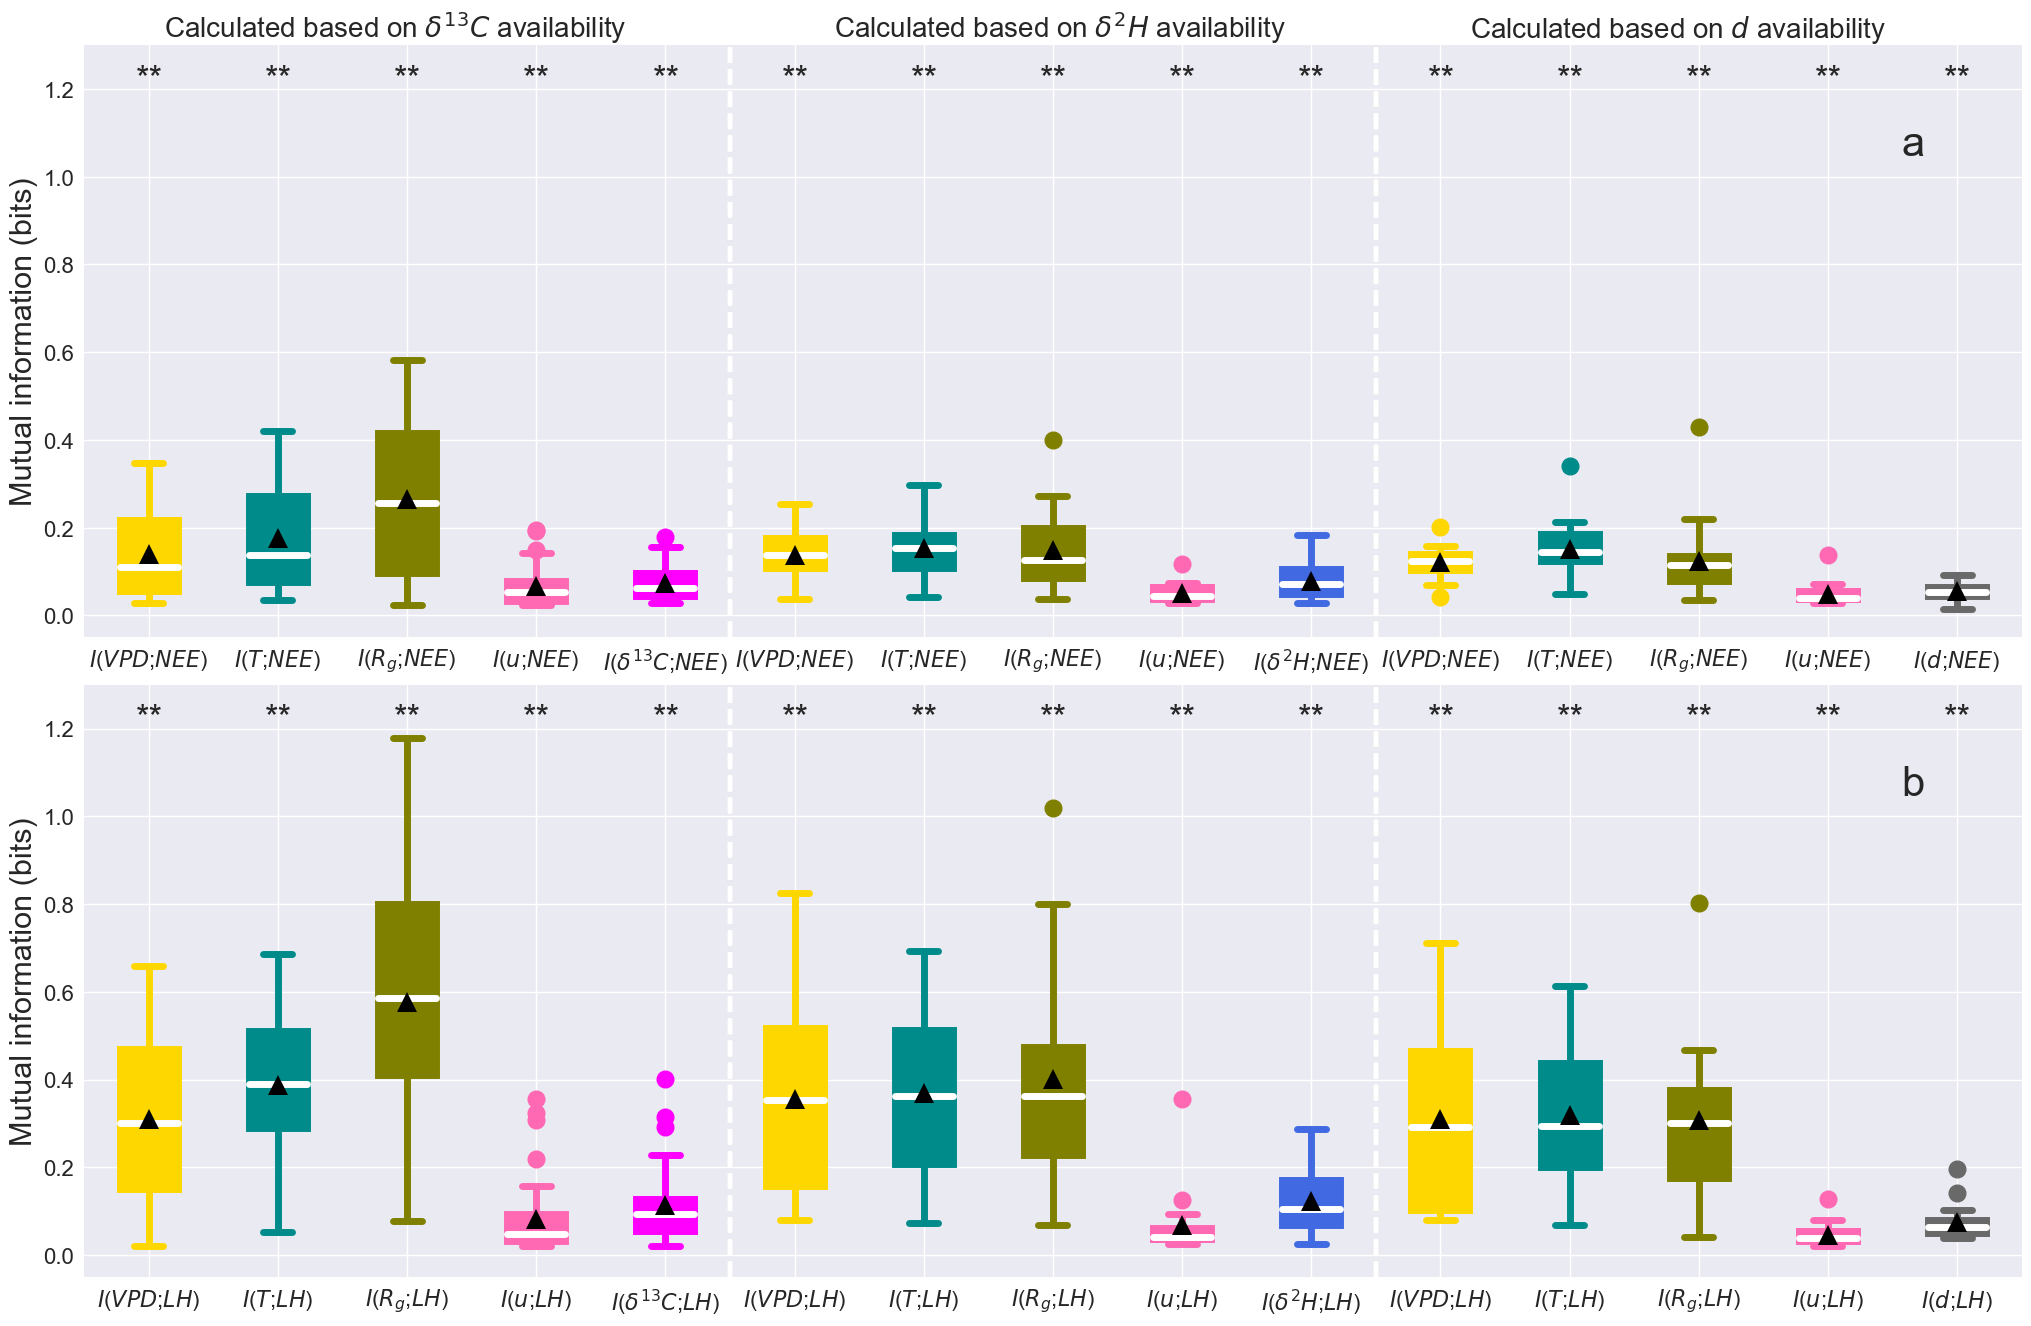

In [222]:
get_fig1(paper_fig_df,"alltime",saveFig=False)

+-----+-------+--------+--------+--------+--------+--------+--------+--------+
| NEE | count | mean   | std    | min    | 25%    | 50%    | 75%    | max    |
+-----+-------+--------+--------+--------+--------+--------+--------+--------+
| VPD | 76.0  | 0.1353 | 0.0737 | 0.0288 | 0.0718 | 0.1233 | 0.1876 | 0.3483 |
+-----+-------+--------+--------+--------+--------+--------+--------+--------+
| T   | 76.0  | 0.1651 | 0.0968 | 0.0354 | 0.0811 | 0.1432 | 0.2181 | 0.421  |
+-----+-------+--------+--------+--------+--------+--------+--------+--------+
| R   | 76.0  | 0.2053 | 0.1516 | 0.0247 | 0.0846 | 0.1543 | 0.296  | 0.5811 |
+-----+-------+--------+--------+--------+--------+--------+--------+--------+
| u   | 76.0  | 0.059  | 0.0365 | 0.0229 | 0.035  | 0.0474 | 0.0705 | 0.1944 |
+-----+-------+--------+--------+--------+--------+--------+--------+--------+
| C13 | 40.0  | 0.0728 | 0.038  | 0.0275 | 0.045  | 0.063  | 0.0972 | 0.1793 |
+-----+-------+--------+--------+--------+--------+-

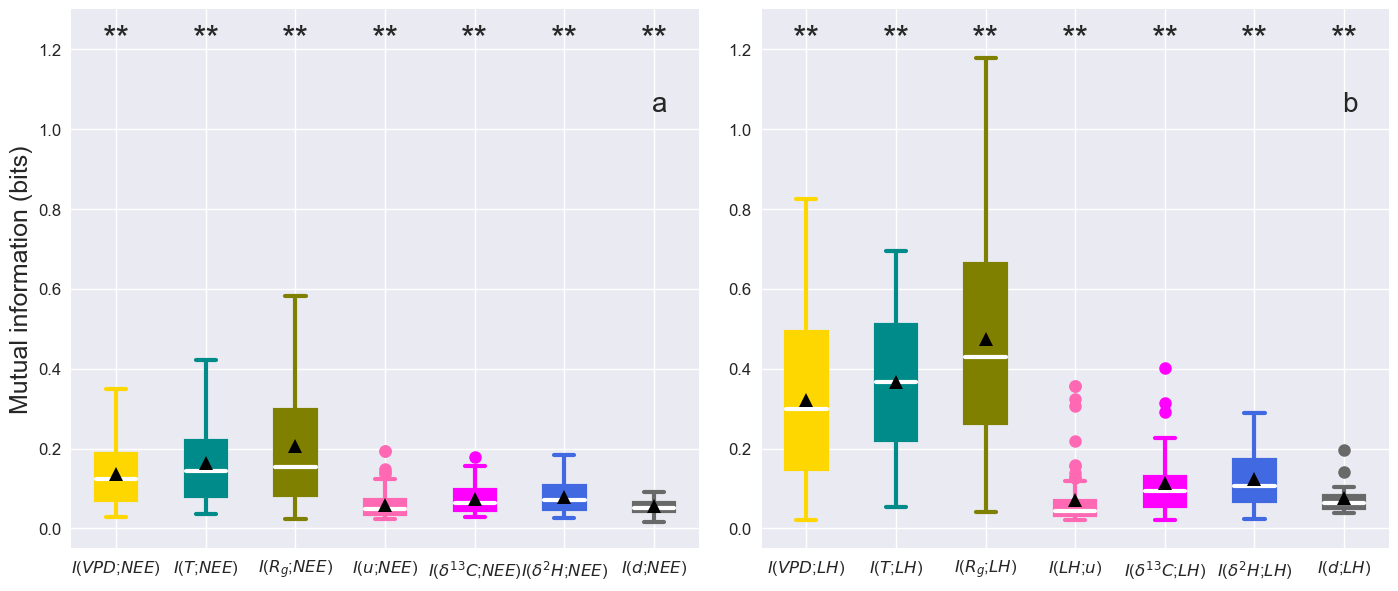

In [223]:
get_stacked_fig1(paper_fig_df, "alltime", saveFig=False)

             pvalues      tstats
I(NEE;VPD)13     0.0  394.611371
I(NEE;T)13       0.0  411.689597
I(NEE;u)13       0.0  273.942194
I(NEE;R)13       0.0  451.901975
I(NEE;C13)       0.0  373.643102
I(LH;VPD)13      0.0  496.844119
I(LH;T)13        0.0  767.486102
I(LH;u)13        0.0  215.665337
I(LH;R)13        0.0  667.602695
I(LH;C13)        0.0  339.829922
U(NEE;C13)       0.0  395.389471
S(NEE;C13)       1.0 -182.485518
R(NEE;C13)       0.0  214.653549
U+S(NEE;C13)     0.0  409.409711
U(LH;C13)        0.0  321.743588
S(LH;C13)        1.0  -88.018153
R(LH;C13)        0.0  263.659545
U+S(LH;C13)      0.0  304.746711
I(NEE;VPD)2      0.0  457.696399
I(NEE;T)2        0.0  377.711974
I(NEE;u)2        0.0   199.23141
I(NEE;R)2        0.0  298.548298
I(NEE;H2)        0.0  235.600745
I(LH;VPD)2       0.0  327.396924
I(LH;T)2         0.0  389.049409
I(LH;u)2         0.0  113.035397
I(LH;R)2         0.0  327.193813
I(LH;H2)         0.0  263.443105
U(NEE;H2)        0.0  235.846367
S(NEE;H2) 

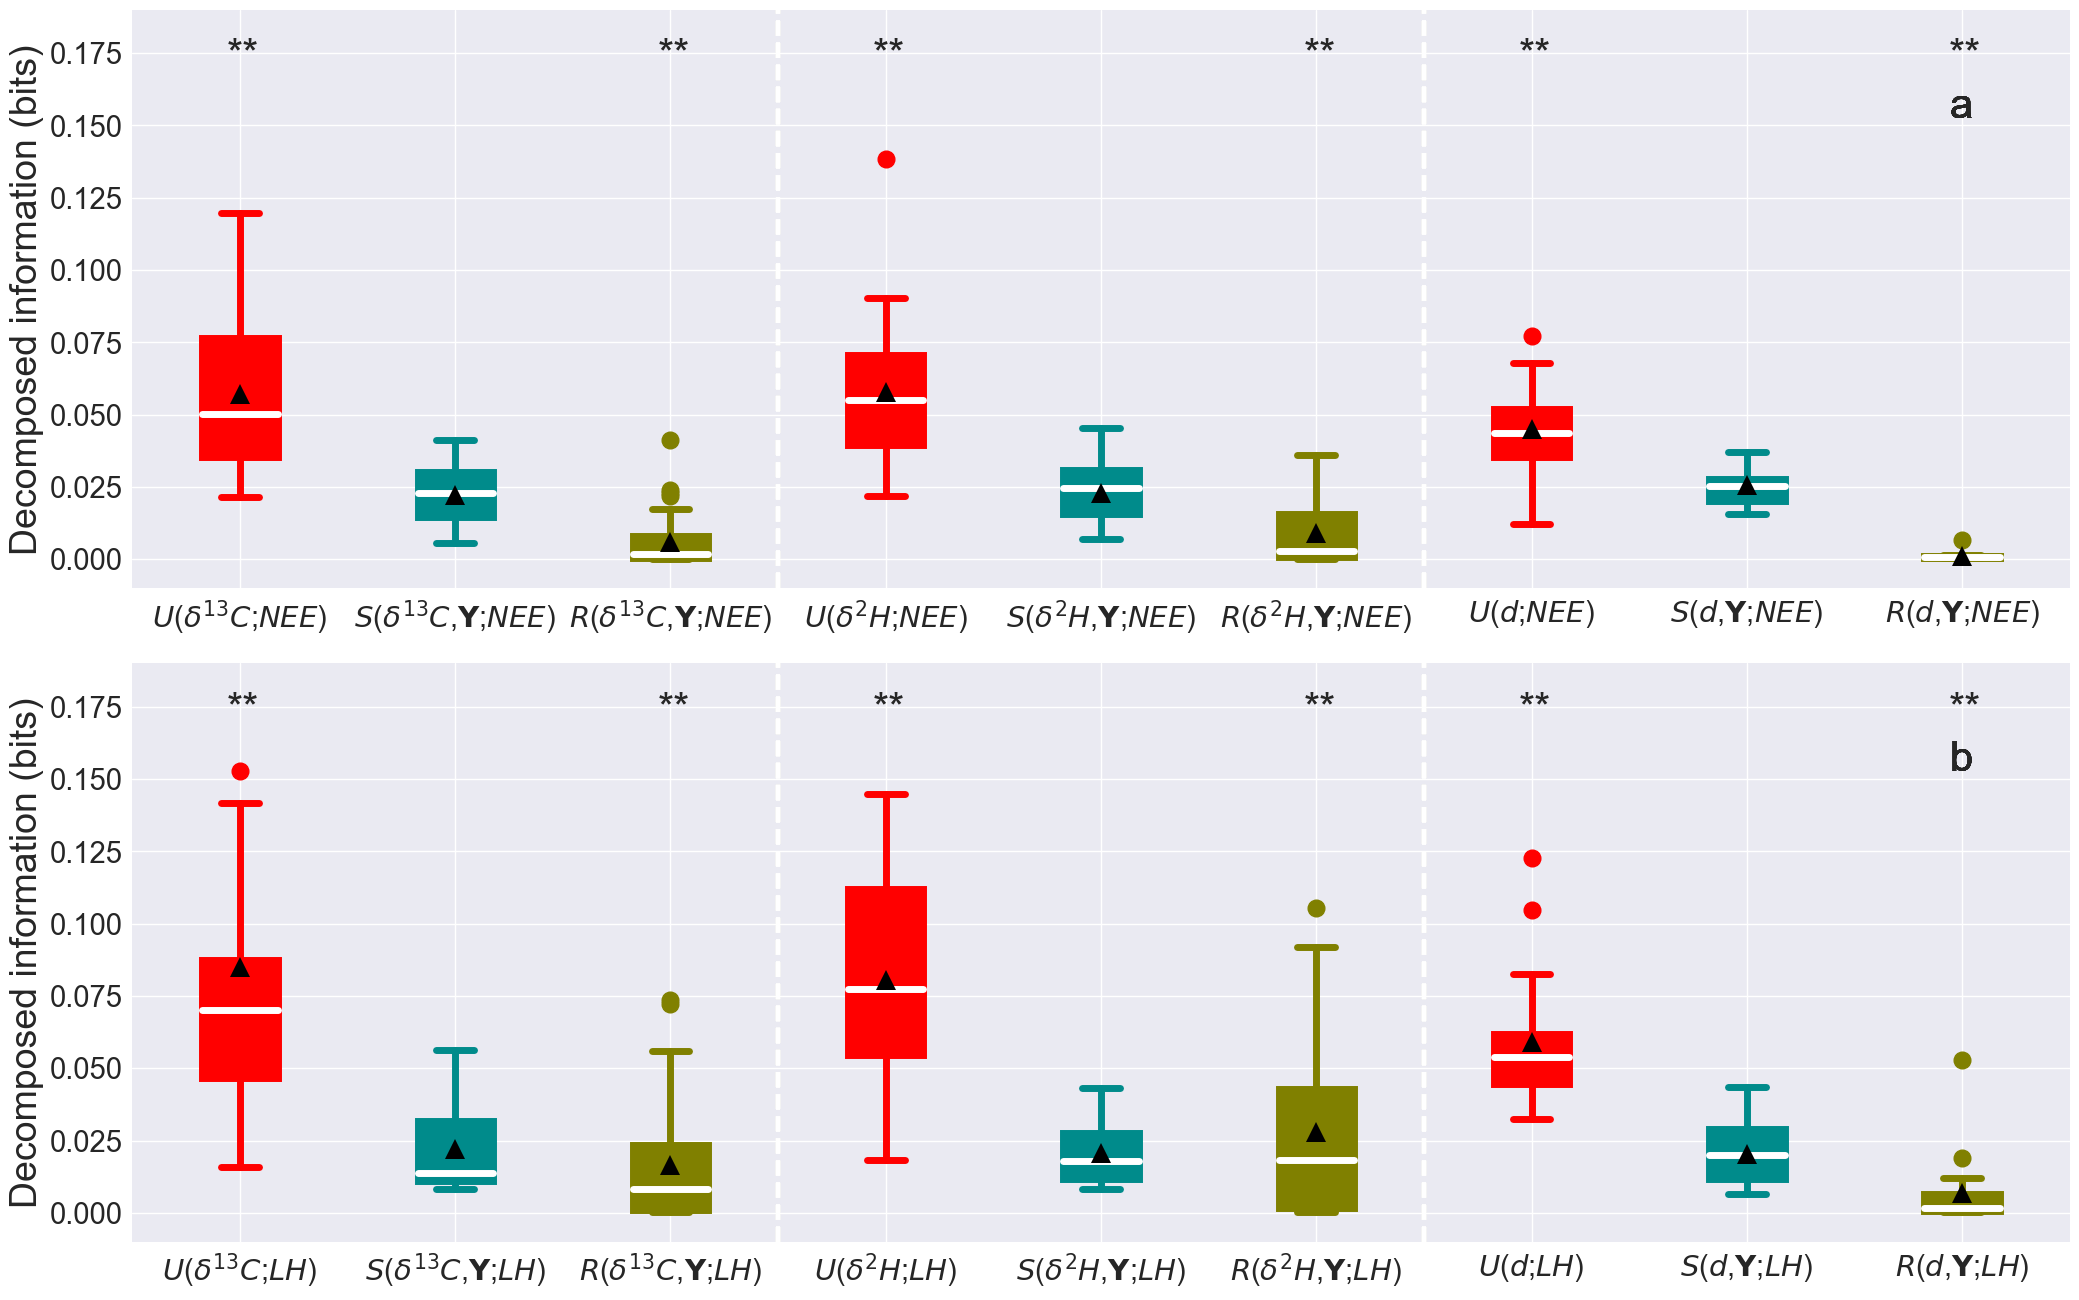

In [224]:
get_fig2(paper_fig_df,"alltime",saveFig=False)

    site  U+S(NEE;C13)  U+S(NEE;H2)  U+S(NEE;dEx)  U+S(LH;C13)  U+S(LH;H2)  \
0   ABBY      0.100216          NaN           NaN     0.074828         NaN   
1   BARR           NaN          NaN           NaN          NaN         NaN   
2   BART      0.129728          NaN           NaN     0.126835         NaN   
3   BLAN      0.060415          NaN           NaN     0.069592         NaN   
4   BONA      0.068152     0.088591      0.087979     0.077672    0.153815   
5   CLBJ      0.098528     0.081870      0.066326     0.085261    0.078506   
6   CPER      0.106397     0.098853      0.055048     0.307253    0.089557   
7   DCFS      0.072477          NaN           NaN     0.090757         NaN   
8   DEJU      0.060043          NaN           NaN     0.075499         NaN   
9   DELA      0.101736          NaN           NaN     0.118325         NaN   
10  DSNY      0.062896          NaN           NaN     0.064482         NaN   
11  GRSM      0.050672          NaN           NaN     0.037274  

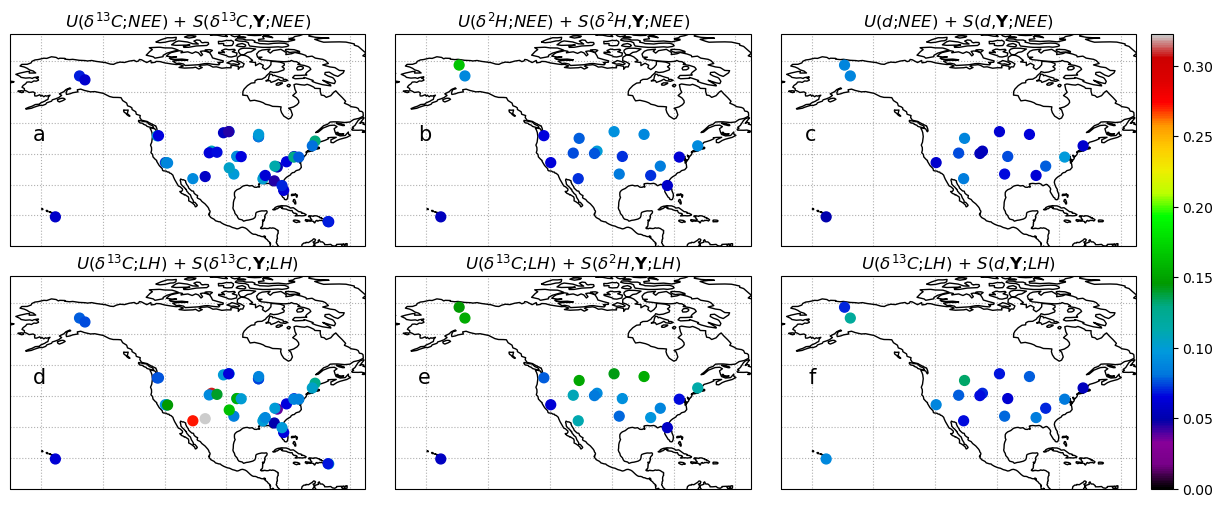

In [233]:
get_spatial_plots(spatial_df, "U+S", saveFig=False, cbarColor="nipy_spectral")

    site  U(NEE;C13)  U(NEE;H2)  U(NEE;dEx)  U(LH;C13)  U(LH;H2)  U(LH;dEx)
0   ABBY    0.086246        NaN         NaN   0.061008       NaN        NaN
1   BARR         NaN        NaN         NaN        NaN       NaN        NaN
2   BART    0.119686        NaN         NaN   0.117330       NaN        NaN
3   BLAN    0.041663        NaN         NaN   0.056926       NaN        NaN
4   BONA    0.039182   0.063208    0.051902   0.045606  0.144928   0.104744
5   CLBJ    0.088526   0.050399    0.038735   0.075782  0.057565   0.049524
6   CPER    0.091344   0.090235    0.034529   0.297341  0.078964   0.061811
7   DCFS    0.042369        NaN         NaN   0.046945       NaN        NaN
8   DEJU    0.027252        NaN         NaN   0.034377       NaN        NaN
9   DELA    0.096077        NaN         NaN   0.110093       NaN        NaN
10  DSNY    0.030937        NaN         NaN   0.037199       NaN        NaN
11  GRSM    0.024972        NaN         NaN   0.015911       NaN        NaN
12  GUAN    

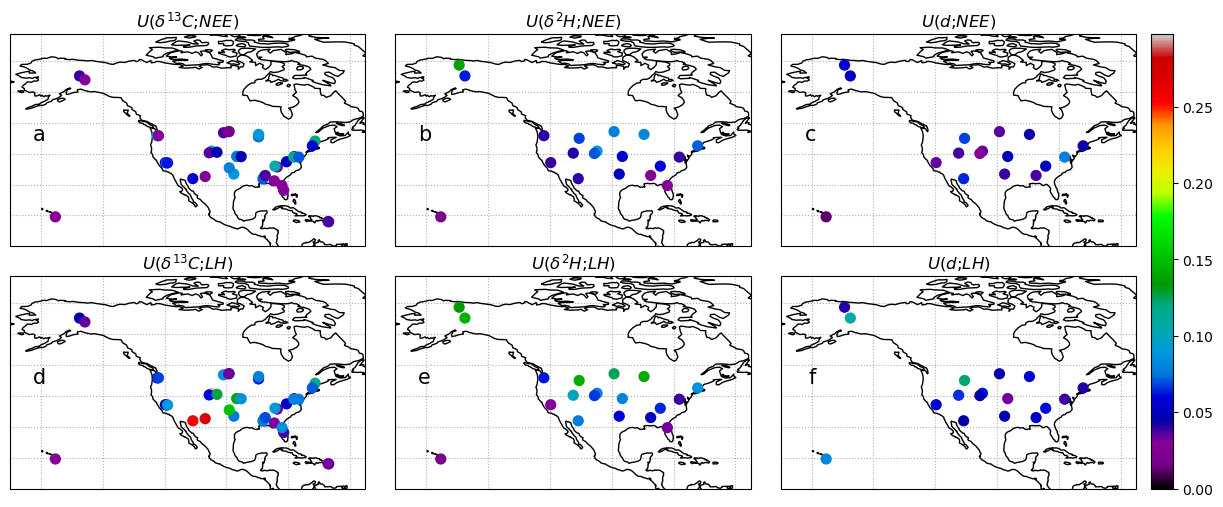

In [226]:
get_spatial_plots(spatial_df, "U", saveFig=False,cbarColor="nipy_spectral")

    site  S(NEE;C13)  S(NEE;H2)  S(NEE;dEx)  S(LH;C13)  S(LH;H2)  S(LH;dEx)
0   ABBY    0.013970        NaN         NaN   0.013820       NaN        NaN
1   BARR         NaN        NaN         NaN        NaN       NaN        NaN
2   BART    0.010042        NaN         NaN   0.009505       NaN        NaN
3   BLAN    0.018752        NaN         NaN   0.012666       NaN        NaN
4   BONA    0.028971   0.025384    0.036077   0.032067  0.008887   0.015729
5   CLBJ    0.010002   0.031470    0.027591   0.009479  0.020941   0.029646
6   CPER    0.015053   0.008618    0.020519   0.009911  0.010593   0.008316
7   DCFS    0.030108        NaN         NaN   0.043812       NaN        NaN
8   DEJU    0.032791        NaN         NaN   0.041122       NaN        NaN
9   DELA    0.005659        NaN         NaN   0.008232       NaN        NaN
10  DSNY    0.031959        NaN         NaN   0.027283       NaN        NaN
11  GRSM    0.025700        NaN         NaN   0.021363       NaN        NaN
12  GUAN    

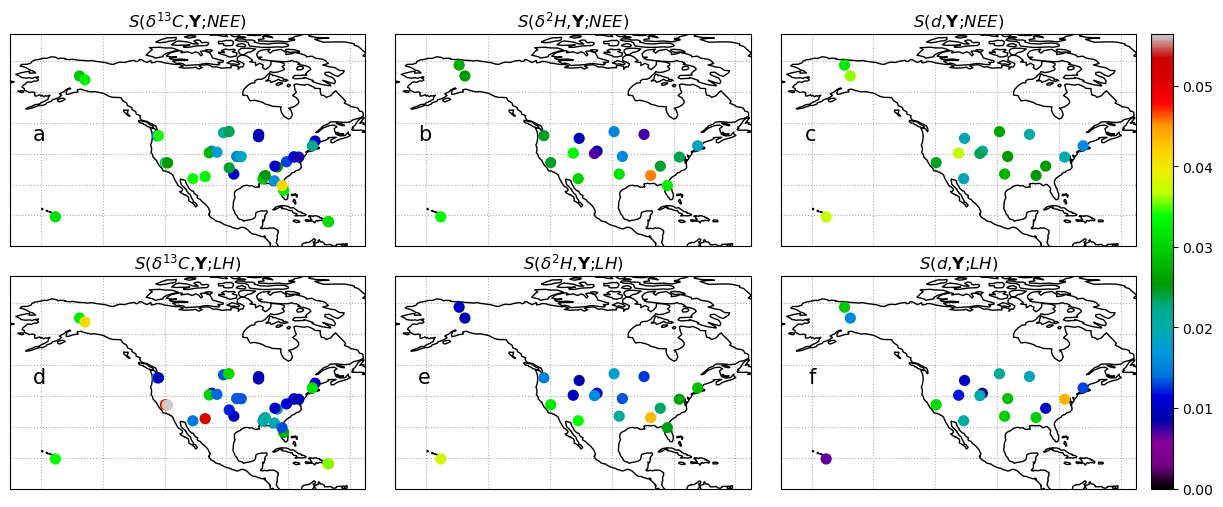

In [227]:
get_spatial_plots(spatial_df, "S", saveFig=False,cbarColor="nipy_spectral")

    site  R(NEE;C13)  R(NEE;H2)  R(NEE;dEx)  R(LH;C13)  R(LH;H2)  R(LH;dEx)
0   ABBY    0.004966        NaN         NaN   0.005446       NaN        NaN
1   BARR         NaN        NaN         NaN        NaN       NaN        NaN
2   BART    0.041115        NaN         NaN   0.041630       NaN        NaN
3   BLAN    0.002576        NaN         NaN   0.008460       NaN        NaN
4   BONA    0.000402   0.008755    0.001616   0.000879  0.105411   0.018978
5   CLBJ    0.017445   0.001878    0.000398   0.020713  0.008796   0.000573
6   CPER    0.008908   0.024095    0.000806   0.073766  0.051931   0.006526
7   DCFS    0.000360        NaN         NaN   0.000621       NaN        NaN
8   DEJU    0.000316        NaN         NaN   0.000343       NaN        NaN
9   DELA    0.023942        NaN         NaN   0.025659       NaN        NaN
10  DSNY    0.000603        NaN         NaN   0.001112       NaN        NaN
11  GRSM    0.000178        NaN         NaN   0.000259       NaN        NaN
12  GUAN    

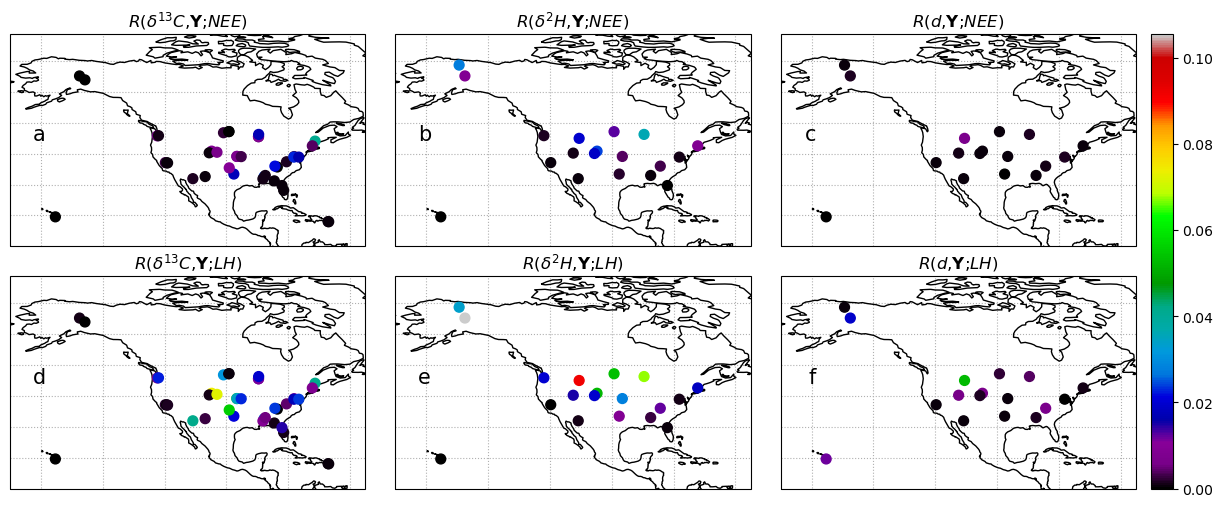

In [228]:
get_spatial_plots(spatial_df, "R", saveFig=False,cbarColor="nipy_spectral")

Display some information of the simple linear regression to 5 digits: 
+------------+-----------+----------+----------+---------+---------+--------------+--------------+
|  Response  | Predictor |  slope   | constant | p-slope |  r2/R2  | max-response | min-response |
+------------+-----------+----------+----------+---------+---------+--------------+--------------+
| U(NEE;C13) |  aridity  | -0.02279 | 0.06130  | 0.30909 | 0.02721 |   0.11969    |   0.02148    |
| U(NEE;C13) |    MAT    | -0.00359 | 0.05887  | 0.84338 | 0.00104 |   0.11969    |   0.02148    |
| U(NEE;C13) |    MAP    | 0.00348  | 0.05589  | 0.85631 | 0.00087 |   0.11969    |   0.02148    |
| U(NEE;C13) |    Elev   | -0.01315 | 0.05980  | 0.50232 | 0.01193 |   0.11969    |   0.02148    |
+------------+-----------+----------+----------+---------+---------+--------------+--------------+

Display some information of the simple linear regression to 5 digits: 
+-----------+-----------+----------+----------+---------+--------

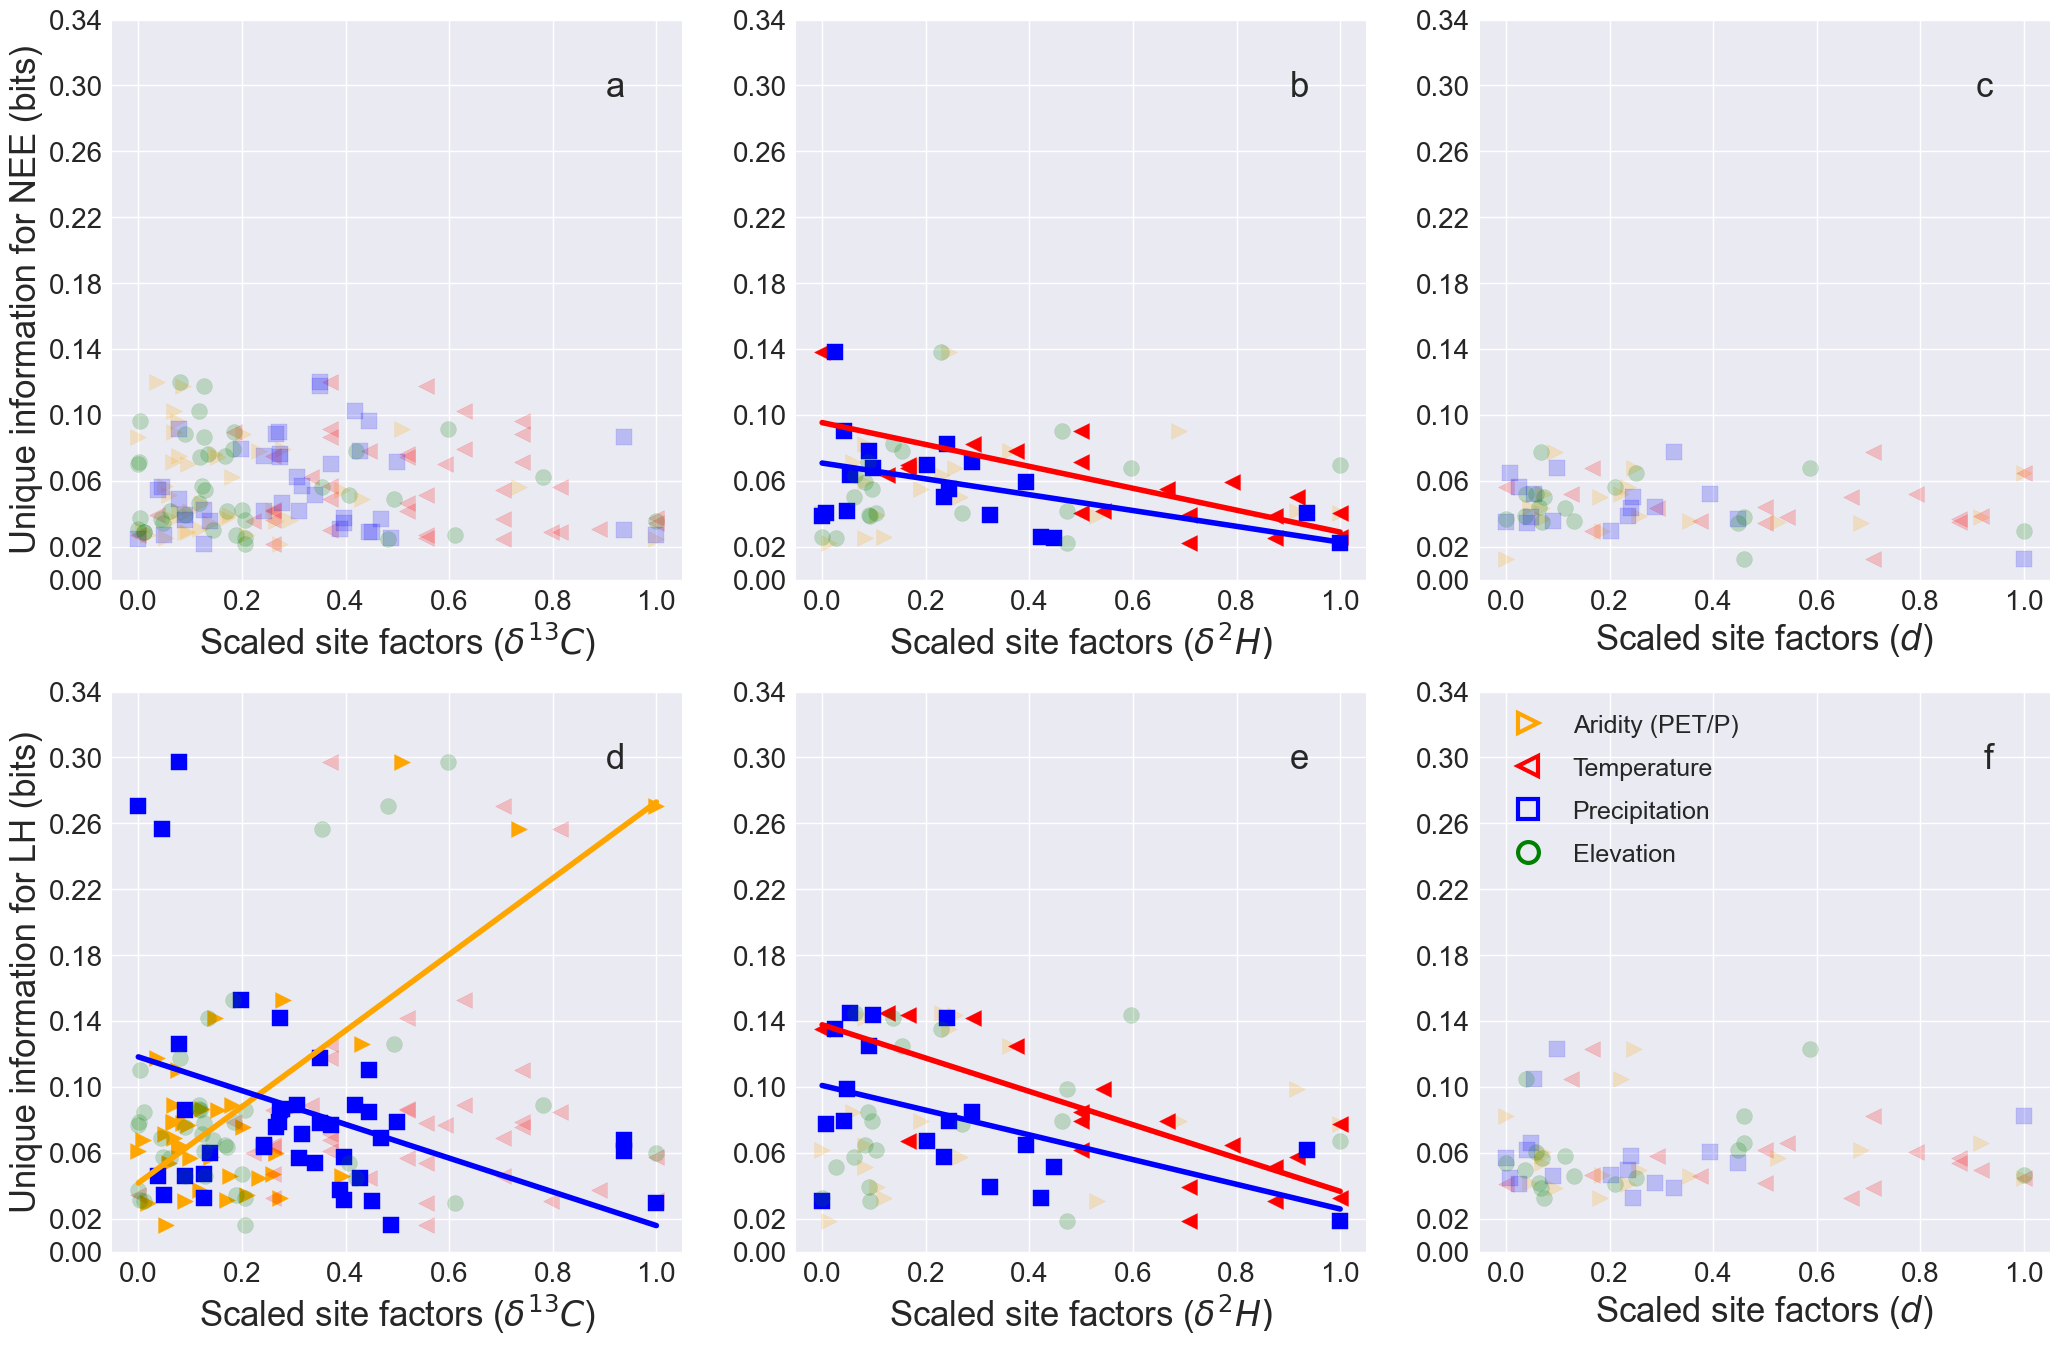

In [229]:
get_fig4(paper_fig_df,plot_part="U",saveFig=False,diag_plot=False)

Display some information of the simple linear regression to 5 digits: 
+--------------+-----------+----------+----------+---------+---------+--------------+--------------+
|   Response   | Predictor |  slope   | constant | p-slope |  r2/R2  | max-response | min-response |
+--------------+-----------+----------+----------+---------+---------+--------------+--------------+
| U+S(NEE;C13) |  aridity  | -0.01000 | 0.08099  | 0.58839 | 0.00778 |   0.12973    |   0.04469    |
| U+S(NEE;C13) |    MAT    | 0.00171  | 0.07823  | 0.90863 | 0.00035 |   0.12973    |   0.04469    |
| U+S(NEE;C13) |    MAP    | 0.00528  | 0.07740  | 0.73815 | 0.00298 |   0.12973    |   0.04469    |
| U+S(NEE;C13) |    Elev   | -0.00643 | 0.08047  | 0.69005 | 0.00423 |   0.12973    |   0.04469    |
+--------------+-----------+----------+----------+---------+---------+--------------+--------------+

Display some information of the simple linear regression to 5 digits: 
+-------------+-----------+----------+----------+

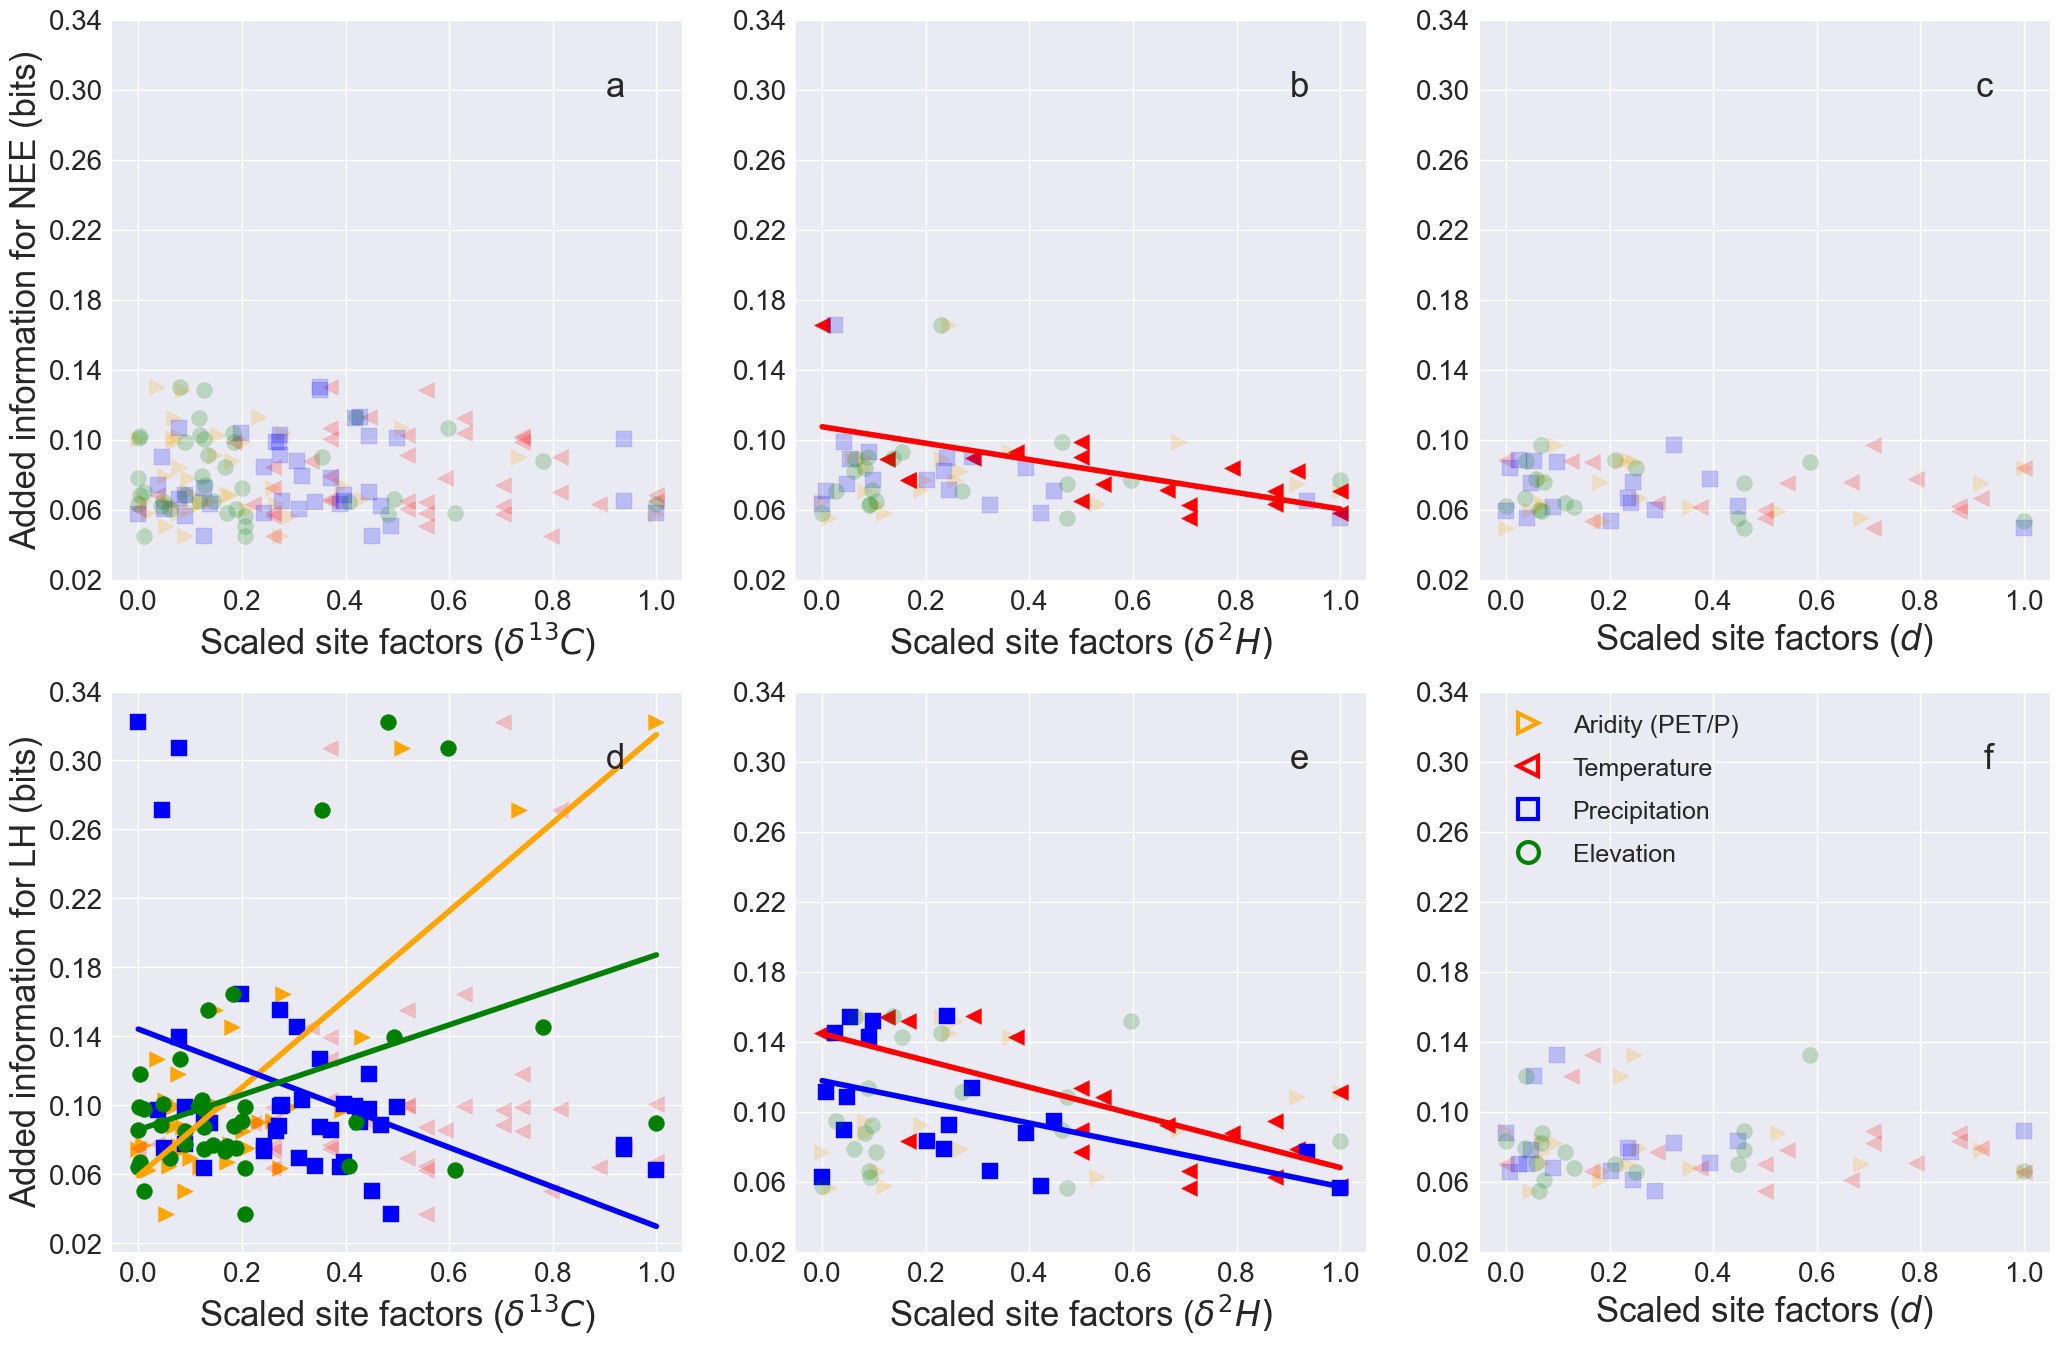

In [230]:
get_fig4(paper_fig_df,plot_part="U+S",saveFig=False,diag_plot=False)

In [231]:
get_statistics(table_stat_df)

              count      mean       std       min       25%       50%  \
I(NEE;VPD)13   40.0  0.140413  0.091923  0.028773  0.055253  0.109532   
I(NEE;T)13     40.0  0.176284  0.115316  0.035352  0.076434  0.136904   
I(NEE;u)13     40.0  0.066531  0.044111  0.022881  0.033024  0.052556   
I(NEE;R)13     40.0  0.266241  0.170012  0.024748  0.096164  0.256563   
I(NEE;C13)     40.0  0.072844  0.038026  0.027458  0.045008  0.062967   
I(LH;VPD)13    40.0  0.310137  0.183841  0.021274  0.150678  0.300159   
I(LH;T)13      40.0  0.387199  0.150648  0.052624  0.290780  0.389456   
I(LH;u)13      40.0  0.082793  0.083630  0.021628  0.031366  0.048623   
I(LH;R)13      40.0  0.576860  0.264418  0.077633  0.411669  0.586064   
I(LH;C13)      40.0  0.114065  0.081930  0.020511  0.055187  0.094578   
U(NEE;C13)     40.0  0.057022  0.027336  0.021480  0.035386  0.050128   
S(NEE;C13)     40.0  0.022089  0.009359  0.005659  0.014782  0.023063   
R(NEE;C13)     40.0  0.006091  0.008943  0.000178  